# Artificial Neural Network and Deep Learning - Challenge 1

## Hyperparameters

In [70]:
############################################################

SEED = 100
USE_SEED = True

# Training
EPOCHS = 300                        # Maximum epochs (increase to improve performance)
PATIENCE = 50                       # Early stopping patience (increase to improve performance)
VERBOSE = 1                         # Print printing frequency
VALIDATION_SPLIT = 0.2              # Validation split ratio


############################################################
# General Paremeters
############################################################

# Loss Function
CROSS_ENTROPY_WEIGHTING = True      # Enable or disable class weighting
WEIGHT_CE_INTENSITY = 2.0           # Intensity of class weighting (higher values increase the effect)
LABEL_SMOOTHING_EPSILON = 0.0       # Label smoothing epsilon (0.0 to disable)

# Optimisation
LEARNING_RATE = 0.001               # Learning rate
BATCH_SIZE = 32                     # Batch size
WINDOW_SIZE = 120                    # Input window size
STRIDE = 20                         # Input stride

# Regularisation
NOISE_STD_DEV = 0.0                 # Data Augmentation: Added noise on training dataset
DROPOUT_RATE = 0.5                  # Dropout probability
L1_LAMBDA = 0.0                     # L1 penalty
L2_LAMBDA = 0.0001                    # L2 penalty

############################################################
# MODEL ARCHITECTURE
############################################################

# Branch 1 CONFIGURATION 
HIDDEN_LAYERS = 3                   # Hidden layers
HIDDEN_SIZE = 128                    # Neurons per layer
RNN_TYPE = 'LSTM'                   # Type of RNN architecture ['RNN', 'LSTM', 'GRU']
BIDIRECTIONAL = True                # Bidirectional RNN

# Branch 2 CONFIGURATION 
USE_STATIC_FEATURES = True          # Enable Training on static features
STATIC_HIDDEN_SIZE = 64             # Size of the new MLP branch

# Branch 3 CONFIGURATION 
PAIN_BRANCH_TYPE = 'GRU'            # Type for pain branch: 'MLP', 'RNN', 'LSTM', or 'GRU'
PAIN_NUM_LAYERS = 2                 # Number of layers for the pain RNN
PAIN_HIDDEN_SIZE = 32               # Neurons for pain branch
PAIN_BRANCH_BIDIRECTIONAL = False   # Bidirectional flag for pain branch


############################################################
# TRAINING MODE AND OPTIONS
############################################################

# Select only one of the following training modes
NORMAL_TRAINING = False
CROSS_VALIDATION_TRAINING = False
GRID_SEARCH = False
BAYESIAN_SEARCH = False
FULL_DATASET_TRAINING = True
ENSEMBLE_TRAINING = False            


# --- CROSS-VALIDATION CONFIGURATION ---
K = 5                               # Number of splits for K-Fold CV
VERBOSE_CV_RUN = 10                 # Set to 1 to see epoch-by-epoch in CV

# --- GRID SEARCH CONFIGURATION ---
GRID_SEARCH_VERBOSE = 1             # Set to 1 to see config-by-config
TOP_N_PLOTS = 10                    # Number of top configurations to plot

# --- FULL DATASET TRAINING CONFIGURATION ---
OPTIMAL_EPOCHS =  40                # Optimal epochs determined from CV

# --- ENSEMBLE TRAINING CONFIGURATION ---
ENSEMBLE_SEEDS = [100, 200, 300]    # List of seeds to use for diversity


############################################################
# Grid Search Hyperparameter Ranges (Empty Values are fixed parameters) 

GS_LEARNING_RATES = []
GS_BATCH_SIZE = [] 
GS_WINDOW_SIZES = [] 
GS_STRIDES = []

GS_CE_INTENSITY = [0.6, 1.0, 2.0]
GS_LABEL_SMOOTHING = [0.0, 0.05, 0.1]

GS_DROPOUT_RATES = [0.1, 0.3, 0.5]
GS_L1_LAMBDA = [] 
GS_L2_LAMBDA = [0.0, 0.01]
GS_NOISE_STD_DEV = [0.0, 0.1, 0.2]

GS_HIDDEN_LAYERS = []
GS_HIDDEN_SIZES = []
GS_RNN_TYPES = []
GS_BIDIRECTIONAL = []

GS_PAIN_BRANCH_TYPES = []
GS_PAIN_NUM_LAYERS = []
GS_PAIN_HIDDEN_SIZES = []
GS_PAIN_BIDIRECTIONAL = []

GS_STATIC_HIDDEN_SIZES = []


############################################################
# Bayesian Search Hyperparameter Ranges 

BS_N_TRIALS = 50                # Number of trials to run

# Optimization
BS_LEARNING_RATE = [LEARNING_RATE]
BS_WEIGHT_CE_INTENSITY = [0.0, 0.6, 1.0, 2.0]
BS_DROPOUT_RATE = [0.0, 0.1, 0.3, 0.5]


BS_HIDDEN_LAYERS = [1, 3]
BS_PAIN_NUM_LAYERS = [1, 2]

# Categorical
BS_WINDOW_SIZE = [40, 80, 120]
BS_STRIDE = [20, 40]
BS_LABEL_SMOOTHING = [0.0, 0.05, 0.1]
BS_HIDDEN_SIZE = [32, 64, 128]
BS_RNN_TYPE = ['LSTM', 'GRU']
BS_BIDIRECTIONAL = [BIDIRECTIONAL]
BS_PAIN_BRANCH_TYPE = [PAIN_BRANCH_TYPE]
BS_PAIN_HIDDEN_SIZE = [16, 32, 64]
BS_PAIN_BRANCH_BIDIRECTIONAL = [PAIN_BRANCH_BIDIRECTIONAL]
BS_STATIC_HIDDEN_SIZE = [16, 32, 64]
BS_L2_LAMBDA = [0.0, 0.01, 1e-3, 1e-4,]
BS_NOISE_STD_DEV = [0.0, 0.1, 0.2]

############################################################


## Libraries and dataset import

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns   
import random
import torch
import os
import sys
from itertools import product
from itertools import chain
import optuna

from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import f1_score
import torch.nn as nn
from datetime import datetime 
import hashlib

import torch.nn.functional as F
from IPython.display import display, clear_output


if USE_SEED:
    print(f"Using fixed random seed: {SEED}")
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
else:
    print("Running with random seed.")


if torch.cuda.is_available():
    device = torch.device("cuda")
    if USE_SEED:
        torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

df_train = pd.read_csv('pirate_pain_train.csv')
df_labels = pd.read_csv('pirate_pain_train_labels.csv')




Using fixed random seed: 100
PyTorch version: 2.9.0+cu128
Device: cuda


## Preprocessing

### Windows Creation

In [72]:

# --- 1. Define feature columns and label map ---
joint_cols = [c for c in df_train.columns if c.startswith('joint_')]
joint_cols = joint_cols[:-1]
pain_cols = [c for c in df_train.columns if c.startswith('pain_survey_')] # Will be processed separately
static_cols_raw = [c for c in df_train.columns if c.startswith('n_')] 

# Branch 1: Main RNN input
temporal_cols_rnn = joint_cols 
# Branch 2: New Pain MLP/RNN input
temporal_cols_pain = pain_cols

# This is no longer the main input_size, but the total temporal features
all_temporal_cols = temporal_cols_rnn + temporal_cols_pain
input_size_rnn = len(temporal_cols_rnn)
input_size_pain = len(temporal_cols_pain)

# Create label map
label_map = {"no_pain": 0, "low_pain": 1, "high_pain": 2}
num_classes = len(label_map)
inv_label_map = {v: k for k, v in label_map.items()} # Needed for plots

print(f"Branch 1 (RNN) Input Features: {input_size_rnn} (Joints)")
print(f"Branch 2 (Pain) Input Features: {input_size_pain} (Surveys)")
print(f"Found Raw Static Feature columns: {static_cols_raw}")
print(f"Label map: {label_map}")

# --- 2. Split by Sample Index (Leakage Fix) ---
unique_sids = df_labels['sample_index'].unique()
train_sids, val_sids = train_test_split(
    unique_sids,
    test_size=VALIDATION_SPLIT,
    random_state=SEED,
    stratify=df_labels['label'] 
)
df_train_split = df_train[df_train['sample_index'].isin(train_sids)]
df_labels_train_split = df_labels[df_labels['sample_index'].isin(train_sids)]
df_val_split = df_train[df_train['sample_index'].isin(val_sids)]
df_labels_val_split = df_labels[df_labels['sample_index'].isin(val_sids)]

# --- 2.5. Calculate Global Normalization Stats (from TRAIN split only) ---
def engineer_static_features(raw_df):
    engineered_df = pd.DataFrame(index=raw_df.index)
    
    if 'n_legs' in raw_df:
        engineered_df['n_legs'] = np.where(raw_df['n_legs'] == '2', 2.0, 1.0)
    if 'n_hands' in raw_df:
        engineered_df['n_hands'] = np.where(raw_df['n_hands'] == '2', 2.0, 1.0)
    if 'n_eyes' in raw_df:
        engineered_df['n_eyes'] = np.where(raw_df['n_eyes'] == '2', 2.0, 1.0)
        
    return engineered_df


print("Calculating global normalization stats from training data...")
# Joints
train_joint_data = df_train_split[joint_cols].values
GLOBAL_JOINT_MIN = np.min(train_joint_data, axis=0)
GLOBAL_JOINT_MAX = np.max(train_joint_data, axis=0)
print(f"Global joint min/max shape: {GLOBAL_JOINT_MIN.shape}")

# Pain
train_pain_data = df_train_split[pain_cols].values
GLOBAL_PAIN_MIN = np.min(train_pain_data, axis=0)
GLOBAL_PAIN_MAX = np.max(train_pain_data, axis=0)
print(f"Global pain min/max shape: {GLOBAL_PAIN_MIN.shape}")

# Static (Engineered)
# We calculate static stats *after* engineering but *before* passing to Dataset
print("\nStarting static feature engineering (for stats)...")
df_static_raw_train = df_train_split.drop_duplicates(subset=['sample_index']).set_index('sample_index')[static_cols_raw]
df_static_engineered_train = engineer_static_features(df_static_raw_train)
df_static_engineered_train = df_static_engineered_train.fillna(2) # Fill NaNs before stats
print("Engineering complete.")

STATIC_FEATURES_LIST_ENGINEERED = list(df_static_engineered_train.columns)
GLOBAL_STATIC_MIN = df_static_engineered_train[STATIC_FEATURES_LIST_ENGINEERED].values.min(axis=0)
GLOBAL_STATIC_MAX = df_static_engineered_train[STATIC_FEATURES_LIST_ENGINEERED].values.max(axis=0)
print(f"Global static min/max shape: {GLOBAL_STATIC_MIN.shape}")
print(f"New static features: {STATIC_FEATURES_LIST_ENGINEERED}")

def build_fixed_sequences(df_features, df_labels, joint_cols, pain_cols, label_map, 
                          joint_min, joint_max, 
                          pain_min, pain_max,  #
                          window=200, stride=50):

    dataset_joints = []
    dataset_pain = []
    labels = []
    sample_indices = []
    
    n_features_joint = len(joint_cols)
    n_features_pain = len(pain_cols)

    print(f"Building fixed sequences with window={window}, stride={stride}...")
    
    joint_range = joint_max - joint_min
    joint_range[joint_range == 0] = 1
    joint_min_tensor = torch.FloatTensor(joint_min)
    joint_range_tensor = torch.FloatTensor(joint_range)

    for sid in df_features['sample_index'].unique():
        
        # 1. Get features for both branches
        temp_df = df_features[df_features['sample_index'] == sid].sort_values('time')
        temp_features_joint = temp_df[joint_cols].values
        temp_features_pain = temp_df[pain_cols].values
        
        # 2. Get label
        label_str = df_labels[df_labels['sample_index'] == sid]['label'].values[0]
        label_numeric = label_map[label_str]

        # 3. Normalize BOTH joint and pain data
        joint_data_tensor = torch.FloatTensor(temp_features_joint)
        normalized_joints = 2 * ((joint_data_tensor - joint_min_tensor) / joint_range_tensor) - 1
        temp_features_joint_norm = normalized_joints.numpy()

        pain_data_tensor = torch.FloatTensor(temp_features_pain)
        pain_range_tensor = torch.FloatTensor(pain_max - pain_min)
        pain_range_tensor[pain_range_tensor == 0] = 1
        pain_min_tensor = torch.FloatTensor(pain_min)
        normalized_pain = 2 * ((pain_data_tensor - pain_min_tensor) / pain_range_tensor) - 1
        temp_features_pain_norm = normalized_pain.numpy()
        
        temp_features_joint_padded = temp_features_joint_norm
        temp_features_pain_padded = temp_features_pain_norm

        # 4. Apply windowing logic
        idx = 0
        while idx + window <= len(temp_features_joint_padded):
            dataset_joints.append(temp_features_joint_padded[idx:idx + window])
            dataset_pain.append(temp_features_pain_padded[idx:idx + window])
            labels.append(label_numeric)
            sample_indices.append(sid) 
            idx += stride

    dataset_joints = np.array(dataset_joints, dtype=np.float32)
    dataset_pain = np.array(dataset_pain, dtype=np.float32)
    labels = np.array(labels, dtype=np.int64)

    return (dataset_joints, dataset_pain), labels, np.array(sample_indices)

# --- 3b. Build all sequences ---
(X_train_joints, X_train_pain), y_train, train_window_sids = build_fixed_sequences(
    df_train_split, df_labels_train_split, 
    joint_cols, pain_cols, label_map,
    joint_min=GLOBAL_JOINT_MIN,  
    joint_max=GLOBAL_JOINT_MAX, 
    pain_min=GLOBAL_PAIN_MIN,   
    pain_max=GLOBAL_PAIN_MAX,    
    window=WINDOW_SIZE,
    stride=STRIDE
)
(X_val_joints, X_val_pain), y_val, val_window_sids = build_fixed_sequences(
    df_val_split, df_labels_val_split, 
    joint_cols, pain_cols, label_map,
    joint_min=GLOBAL_JOINT_MIN,  
    joint_max=GLOBAL_JOINT_MAX, 
    pain_min=GLOBAL_PAIN_MIN,   
    pain_max=GLOBAL_PAIN_MAX,  
    window=WINDOW_SIZE,
    stride=STRIDE
)
print(f"\nTotal windows created (Train): {len(y_train)}")
print(f"Total windows created (Val):   {len(y_val)}")

# --- 4. Static Data ---
print("\nStarting static feature engineering...")

# Get raw static features
df_static_raw = df_train.drop_duplicates(subset=['sample_index']).set_index('sample_index')[static_cols_raw]
df_static_engineered = engineer_static_features(df_static_raw)
print("Engineering complete.")

# Fill NaNs before normalization
df_static_engineered = df_static_engineered.fillna(2)[STATIC_FEATURES_LIST_ENGINEERED] # Ensure column order
print(f"\nCreated non-normalized static features for {len(df_static_engineered)} samples.")

# ---  Normalize static features ---
static_range = GLOBAL_STATIC_MAX - GLOBAL_STATIC_MIN
static_range[static_range == 0] = 1
df_static_normalized = 2 * ((df_static_engineered - GLOBAL_STATIC_MIN) / static_range) - 1
print(f"Normalized static features using GLOBAL train stats.")


# --- 5. PainDataset (now returns 3 inputs) ---
class PainDataset(Dataset):
    def __init__(self, X_joints, X_pain, y, window_sample_indices, static_df, 
                 is_train=False, n_joint_cols=0, noise_level=0.01):
        
        self.X_joints = torch.tensor(X_joints, dtype=torch.float32)
        self.X_pain = torch.tensor(X_pain, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        self.window_sample_indices = window_sample_indices
        self.static_data = torch.tensor(static_df.values, dtype=torch.float32)
        self.static_map = {sid: i for i, sid in enumerate(static_df.index)}
        self.is_train = is_train
        self.n_joint_cols = n_joint_cols
        self.noise_level = noise_level
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        x_joints_sample = self.X_joints[idx].clone() 
        x_pain_sample = self.X_pain[idx]
        y_sample = self.y[idx]
        
        if self.is_train and self.noise_level > 0:
            noise = torch.randn(x_joints_sample.shape[0], self.n_joint_cols) * self.noise_level
            x_joints_sample[:, :self.n_joint_cols] = x_joints_sample[:, :self.n_joint_cols] + noise.to(x_joints_sample.device)
        
        sample_index = self.window_sample_indices[idx]
        static_idx_lookup = self.static_map.get(sample_index)
        
        if static_idx_lookup is None:
            print(f"Warning: Missing static data for sample_index {sample_index}. Returning zeros.")
            x_static_sample = torch.zeros(self.static_data.shape[1], dtype=torch.float32)
        else:
            x_static_sample = self.static_data[static_idx_lookup]
            
        # Return a tuple of three inputs
        return (x_joints_sample, x_pain_sample, x_static_sample), y_sample

# --- 6. Create new DataLoaders ---
n_joint_cols = len(joint_cols) # For noise application

train_dataset = PainDataset(
    X_train_joints, X_train_pain, y_train, train_window_sids, df_static_normalized,
    is_train=True, 
    n_joint_cols=n_joint_cols, 
    noise_level=NOISE_STD_DEV
)
val_dataset = PainDataset(
    X_val_joints, X_val_pain, y_val, val_window_sids, df_static_normalized,
    is_train=False
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Branch 1 (RNN) Input Features: 30 (Joints)
Branch 2 (Pain) Input Features: 4 (Surveys)
Found Raw Static Feature columns: ['n_legs', 'n_hands', 'n_eyes']
Label map: {'no_pain': 0, 'low_pain': 1, 'high_pain': 2}
Calculating global normalization stats from training data...
Global joint min/max shape: (30,)
Global pain min/max shape: (4,)

Starting static feature engineering (for stats)...
Engineering complete.
Global static min/max shape: (3,)
New static features: ['n_legs', 'n_hands', 'n_eyes']
Building fixed sequences with window=120, stride=20...
Building fixed sequences with window=120, stride=20...

Total windows created (Train): 1584
Total windows created (Val):   399

Starting static feature engineering...
Engineering complete.

Created non-normalized static features for 661 samples.
Normalized static features using GLOBAL train stats.


--- Plotting a single sample's features ---
Plotting sample_index: 7 (Label: no_pain)


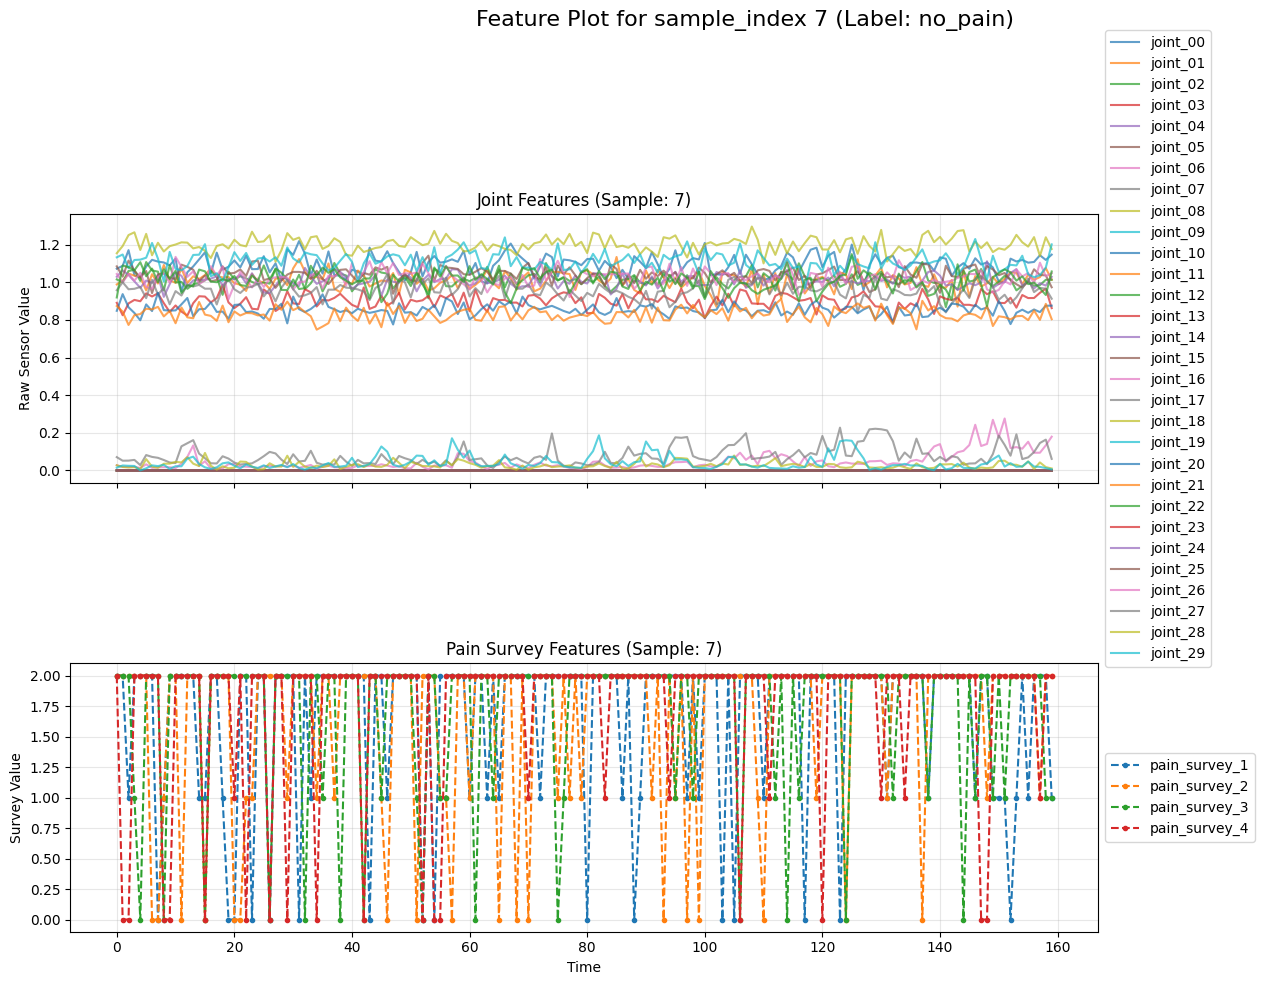

In [73]:
# --- New Cell for Plotting a Single Sample ---
print("--- Plotting a single sample's features ---")

# 1. Select a sample index to plot
# We'll just pick the first one from the training set
plot_sid = train_sids[0]
plot_label = df_labels[df_labels['sample_index'] == plot_sid]['label'].values[0]

print(f"Plotting sample_index: {plot_sid} (Label: {plot_label})")

# 2. Get the original data for this sample
sample_df = df_train[df_train['sample_index'] == plot_sid].sort_values('time')

# 3. Create the plot
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), sharex=True)

# 4. Plot all joint_cols on the first subplot
for col in joint_cols:
    ax1.plot(sample_df['time'], sample_df[col], label=col, alpha=0.7)
ax1.set_title(f"Joint Features (Sample: {plot_sid})")
ax1.set_ylabel("Raw Sensor Value")
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.grid(alpha=0.3)

# 5. Plot all pain_cols on the second subplot
for col in pain_cols:
    ax2.plot(sample_df['time'], sample_df[col], label=col, linestyle='--', marker='o', markersize=3)
ax2.set_title(f"Pain Survey Features (Sample: {plot_sid})")
ax2.set_xlabel("Time")
ax2.set_ylabel("Survey Value")
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.grid(alpha=0.3)

plt.suptitle(f"Feature Plot for sample_index {plot_sid} (Label: {plot_label})", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.85, 0.97]) 
plt.show()

### Cross Entropy weighting

label
no_pain      0.773071
low_pain     0.142209
high_pain    0.084720
Name: proportion, dtype: float64


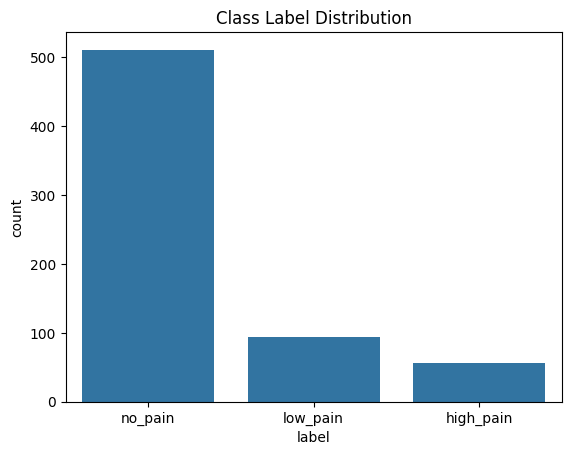


--- Calculating and Applying Class Weights ---
Label proportions:
 label
high_pain    0.084720
low_pain     0.142209
no_pain      0.773071
Name: proportion, dtype: float64
Calculated Weights:
 label
high_pain    0.586395
low_pain     0.349342
no_pain      0.064263
Name: proportion, dtype: float64
--- Label Smoothing is DISABLED ---


In [74]:
print(df_labels['label'].value_counts(normalize=True))

sns.countplot(x='label', data=df_labels)
plt.title('Class Label Distribution')
plt.show()

weights_tensor = None
smoothing_value = 0.0 

label_proportions = df_labels['label'].value_counts(normalize=True).sort_index()

if CROSS_ENTROPY_WEIGHTING:
    print("\n--- Calculating and Applying Class Weights ---")
    print("Label proportions:\n", label_proportions)
    
    # Calculate weights (1 / proportion)
    weights = 1.0 / label_proportions
    weights = weights / weights.sum()
    print("Calculated Weights:\n", weights)
    
    weights_tensor = torch.tensor(weights.values, dtype=torch.float32).to(device)
else:
    print("\n--- Using Unweighted Cross Entropy Loss ---")

if LABEL_SMOOTHING_EPSILON > 0.0:
    smoothing_value = LABEL_SMOOTHING_EPSILON
    print(f"--- Applying Label Smoothing with Epsilon = {smoothing_value} ---")
else:
    print("--- Label Smoothing is DISABLED ---")

CRITERION = nn.CrossEntropyLoss(
    weight=weights_tensor,               
    label_smoothing=smoothing_value      
)

## Neural Network Model

### Recurrent and Hybrid Classifier

In [75]:
class RecurrentClassifier(nn.Module):
    """
    This is the STANDARD (single-input) model.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',
            bidirectional=False,
            dropout_rate=0.2
            ):
        super().__init__()
        self.batch_norm = nn.BatchNorm1d(input_size)
        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        rnn_map = {'RNN': nn.RNN, 'LSTM': nn.LSTM, 'GRU': nn.GRU}
        rnn_module = rnn_map[rnn_type]
        dropout_val = dropout_rate if num_layers > 1 else 0
        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout_val
        )
        if self.bidirectional:
            classifier_input_size = hidden_size * 2
        else:
            classifier_input_size = hidden_size
        self.classifier = nn.Linear(classifier_input_size, num_classes)

    def forward(self, x):
        x = self.batch_norm(x.transpose(1, 2)).transpose(1, 2)
        rnn_out, hidden = self.rnn(x)
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]
        if self.bidirectional:
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            hidden_to_classify = hidden[-1]
        logits = self.classifier(hidden_to_classify)
        return logits
    
    

class HybridClassifier(nn.Module):

    def __init__(
            self,
            rnn_input_size,      # Branch 1 (Joints)
            pain_input_size,     # Branch 2 (Pain Surveys)
            static_input_size,   # Branch 3 (Static)
            rnn_hidden_size,
            pain_hidden_size,    # Size for the new pain branch
            static_hidden_size,
            num_layers,
            pain_num_layers,     
            num_classes,
            rnn_type='LSTM',
            pain_branch_type='MLP',  # 'MLP', 'RNN', 'LSTM', 'GRU'
            pain_bidirectional=False, 
            bidirectional=False,
            dropout_rate=0.2
            ):
        super().__init__()
        
        # Store key properties
        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.rnn_hidden_size = rnn_hidden_size
        self.bidirectional = bidirectional
        
        self.pain_branch_type = pain_branch_type
        self.pain_hidden_size = pain_hidden_size 
        self.pain_num_layers = pain_num_layers   
        self.pain_bidirectional = pain_bidirectional
        
        rnn_map = {'RNN': nn.RNN, 'LSTM': nn.LSTM, 'GRU': nn.GRU}
        rnn_module = rnn_map[rnn_type]
        
        # Dropout for main RNN
        dropout_val = dropout_rate if num_layers > 1 else 0
        
        # --- NEW: Hardcoded CNN Hyperparameters ---
        # (Since we cannot change the __init__ signature)
        self.cnn_joints_out_channels = 128
        self.cnn_pain_out_channels = 64
        cnn_kernel_size = 5
        # --- END NEW ---

        # --- Branch 1: RNN for Temporal Joint Data ---
        self.temporal_batch_norm = nn.BatchNorm1d(rnn_input_size)
        
        # --- NEW: 1D CNN for Joints ---
        self.conv_block_joints = nn.Sequential(
            nn.Conv1d(
                in_channels=rnn_input_size,
                out_channels=self.cnn_joints_out_channels,
                kernel_size=cnn_kernel_size,
                padding='same' # Keeps sequence length the same
            ),
            nn.ReLU()
        )
        # --- END NEW ---

        # --- MODIFIED: RNN for Joints ---
        self.rnn = rnn_module(
            input_size=self.cnn_joints_out_channels, # <-- MODIFIED
            hidden_size=rnn_hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout_val
        )
        rnn_output_size = rnn_hidden_size * (2 if bidirectional else 1)
        
        # --- Branch 2: Processor for Pain Survey Data ---
        self.pain_batch_norm = nn.BatchNorm1d(pain_input_size)
        
        # --- NEW: 1D CNN for Pain ---
        self.conv_block_pain = nn.Sequential(
            nn.Conv1d(
                in_channels=pain_input_size,
                out_channels=self.cnn_pain_out_channels,
                kernel_size=cnn_kernel_size,
                padding='same'
            ),
            nn.ReLU()
        )
        # --- END NEW ---

        # --- MODIFIED: Pain Branch ---
        if self.pain_branch_type in ['RNN', 'LSTM', 'GRU']:
            pain_rnn_module = rnn_map[self.pain_branch_type]
            pain_dropout_val = dropout_rate if self.pain_num_layers > 1 else 0
            
            self.pain_rnn = pain_rnn_module(
                input_size=self.cnn_pain_out_channels, # <-- MODIFIED
                hidden_size=pain_hidden_size,
                num_layers=self.pain_num_layers, 
                batch_first=True,
                bidirectional=self.pain_bidirectional,
                dropout=pain_dropout_val 
            )
            pain_output_size = pain_hidden_size * (2 if self.pain_bidirectional else 1)
        else:
            # Option B: An MLP that processes the *mean* of the CNN-processed pain window
            self.pain_mlp = nn.Sequential(
                nn.Linear(self.cnn_pain_out_channels, pain_hidden_size), # <-- MODIFIED
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            )
            pain_output_size = pain_hidden_size
        # --- END MODIFIED ---

        # --- Branch 3: MLP for Static Data ---
        self.static_mlp = nn.Sequential(
            nn.Linear(static_input_size, static_hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # --- Attention Mechanism ---
        self.attention_score = nn.Linear(rnn_output_size, 1)

        # --- Gated Fusion Head ---
        fused_input_size = rnn_output_size + pain_output_size + static_hidden_size
        self.fusion_gate = nn.Linear(fused_input_size, fused_input_size)
        self.classifier = nn.Linear(fused_input_size, num_classes)

    def forward(self, x_joints, x_pain, x_static):
        
        # --- 1. Process Temporal (Joints) ---
        # Input x_joints: (B, T, C)
        # Transpose to (B, C, T) for BatchNorm and Conv1d
        x_joints_t = x_joints.transpose(1, 2)
        x_joints_bn = self.temporal_batch_norm(x_joints_t)
        
        # NEW: Apply 1D CNN
        # Input: (B, C_in, T) -> Output: (B, C_out, T)
        cnn_out_joints = self.conv_block_joints(x_joints_bn)
        
        # Transpose back to (B, T, C_out) for RNN
        rnn_in_joints = cnn_out_joints.transpose(1, 2)
        
        # MODIFIED: Run RNN on CNN features
        rnn_out, hidden = self.rnn(rnn_in_joints)

        # --- 2. Attention Logic (Unchanged) ---
        attn_scores = self.attention_score(rnn_out)
        attn_weights = F.softmax(attn_scores, dim=1)
        context_vector = torch.sum(attn_weights * rnn_out, dim=1)
        temporal_features = context_vector
        
            
        # --- 3. Process Pain Surveys ---
        # Input x_pain: (B, T, C)
        # Transpose to (B, C, T) for BatchNorm and Conv1d
        x_pain_t = x_pain.transpose(1, 2)
        x_pain_bn = self.pain_batch_norm(x_pain_t)
        
        # NEW: Apply 1D CNN
        # Input: (B, C_in, T) -> Output: (B, C_out, T)
        cnn_out_pain = self.conv_block_pain(x_pain_bn)
        
        # Transpose back to (B, T, C_out) for RNN or MLP
        pain_seq_features = cnn_out_pain.transpose(1, 2)

        # MODIFIED: Process CNN-extracted features
        if self.pain_branch_type in ['RNN', 'LSTM', 'GRU']:
            pain_out, pain_hidden = self.pain_rnn(pain_seq_features) # <-- MODIFIED
            
            if self.pain_branch_type == 'LSTM':
                pain_hidden = pain_hidden[0] 
            
            if self.pain_bidirectional:
                pain_hidden = pain_hidden.view(self.pain_num_layers, 2, -1, self.pain_hidden_size)
                pain_features = torch.cat([pain_hidden[-1, 0, :, :], pain_hidden[-1, 1, :, :]], dim=1)
            else:
                pain_features = pain_hidden[-1]
        else:
            # Process the mean of the CNN features
            x_pain_mean = torch.mean(pain_seq_features, dim=1) # <-- MODIFIED
            pain_features = self.pain_mlp(x_pain_mean)

        # --- 4. Process Static Data (Unchanged) ---
        static_features = self.static_mlp(x_static)

        # --- 5. Gated Fusion (Unchanged) ---
        combined_features = torch.cat([temporal_features, pain_features, static_features], dim=1)
        gate = torch.sigmoid(self.fusion_gate(combined_features))
        gated_features = combined_features * gate

        # --- 6. Classify (Unchanged) ---
        logits = self.classifier(gated_features)

        return logits

### One Epoch Training

In [76]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0):

    model.train()
    running_criterion_loss = 0.0
    all_predictions = []
    all_targets = []

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        x_joints, x_pain, x_static = inputs
        
        # Move all data to device individually
        x_joints = x_joints.to(device)
        x_pain = x_pain.to(device)
        x_static = x_static.to(device)
        targets = targets.to(device)

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(x_joints, x_pain, x_static) 
            
            criterion_loss = criterion(logits, targets)
            
            if torch.isnan(criterion_loss):
                print(f"NaN loss at batch {batch_idx}")
                continue
            
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            total_loss = criterion_loss + l1_lambda * l1_norm
            
        scaler.scale(total_loss).backward() # Use total_loss
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        running_criterion_loss += criterion_loss.item() * targets.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    epoch_loss = running_criterion_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )
    return epoch_loss, epoch_f1

def train_one_epoch_standard(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0):

    model.train()
    running_criterion_loss = 0.0
    all_predictions = []
    all_targets = []
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device) # Single input
        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs) # Single input
            criterion_loss = criterion(logits, targets)
            if torch.isnan(criterion_loss):
                print(f"NaN loss at batch {batch_idx}")
                continue

            l1_norm = sum(p.abs().sum() for p in model.parameters())
            total_loss = criterion_loss + l1_lambda * l1_norm

        scaler.scale(total_loss).backward() # Use total_loss
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        running_criterion_loss += criterion_loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())
    epoch_loss = running_criterion_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(np.concatenate(all_targets), np.concatenate(all_predictions), average='weighted')
    return epoch_loss, epoch_f1

### One Epoch Validation

In [77]:
def validate_one_epoch(model, val_loader, criterion, device):

    model.eval()
    running_loss = 0.0
    all_probabilities = [] # We'll collect probabilities
    all_targets = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            x_joints, x_pain, x_static = inputs
            
            x_joints = x_joints.to(device)
            x_pain = x_pain.to(device)
            x_static = x_static.to(device)
            targets_device = targets.to(device) # Send to device for loss calculation

            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(x_joints, x_pain, x_static)
                loss = criterion(logits, targets_device)

            probabilities = torch.softmax(logits, dim=1).cpu().numpy()
            all_probabilities.append(probabilities)
            
            running_loss += loss.item() * targets.size(0)
            all_targets.append(targets.cpu().numpy()) # Collect original CPU targets

    epoch_loss = running_loss / len(val_loader.dataset)
    
    return epoch_loss, np.concatenate(all_probabilities), np.concatenate(all_targets)

def validate_one_epoch_standard(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device) # Single input
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs) # Single input
                loss = criterion(logits, targets)
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_f1 = f1_score(np.concatenate(all_targets), np.concatenate(all_predictions), average='weighted')
    return epoch_loss, epoch_f1


### Neural Network Fitting

In [78]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name="",
        use_hybrid_functions=False): 

    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0
        
    print(f"Training {epochs} epochs...")

    for epoch in range(1, epochs + 1):

        # --- 1. TRAINING  ---
        if use_hybrid_functions:
            train_loss, train_f1 = train_one_epoch(
                model, train_loader, criterion, optimizer, scaler, device, l1_lambda
            )
        else:
            train_loss, train_f1 = train_one_epoch_standard(
                model, train_loader, criterion, optimizer, scaler, device, l1_lambda
            )
        
        # --- 2. VALIDATION ---
        
        # 2a. Run validation to get window-level probabilities
        if use_hybrid_functions:
            val_loss, window_probs, window_targets = validate_one_epoch(
                model, val_loader, criterion, device
            )
        else:
            val_loss, window_probs, window_targets = validate_one_epoch_standard(
                model, val_loader, criterion, device
            )
        
        # 2b. Aggregate window scores to per-sample scores
        try:
            # Get the sample indices for each window (relies on un-shuffled val_loader)
            all_val_sids = val_loader.dataset.window_sample_indices
            
            # Create the analysis DataFrame
            score_cols = [inv_label_map[i] for i in range(num_classes)]
            df_val_agg = pd.DataFrame(window_probs, columns=score_cols)
            df_val_agg['actual_label_int'] = window_targets
            df_val_agg['sample_index'] = all_val_sids
            
            # Aggregate by sample_index 
            val_mean_probs = df_val_agg.groupby('sample_index')[score_cols].mean()
            val_true_labels_int = df_val_agg.groupby('sample_index')['actual_label_int'].first()
            
            # Get per-sample predictions 
            val_pred_labels_str = val_mean_probs.idxmax(axis=1)
            val_pred_labels_int = val_pred_labels_str.map(label_map).values
            
            # 6. Calculate the PER-SAMPLE F1 score
            val_f1 = f1_score(val_true_labels_int, val_pred_labels_int, average='weighted', zero_division=0)
            
            metric_source = "(Per-Sample)"
            
        except Exception as e:
            print(f"\nWarning: Could not perform per-sample validation. Defaulting to per-window. Error: {e}\n")
            # Fallback to old per-window logic if something goes wrong
            val_f1 = f1_score(window_targets, window_probs.argmax(axis=1), average='weighted', zero_division=0)
            metric_source = "(Per-Window)"

            
        # 3. Log history
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1) # <-- This is now the sample-level F1

        # 4. Print results
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1={val_f1:.4f} {metric_source}") # <-- Added note
        
        # 5. Early stopping (no changes needed, it now uses the correct val_f1)
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                
                save_path = "models/" + experiment_name + '_model.pt'
                save_dir = os.path.dirname(save_path)
                os.makedirs(save_dir, exist_ok=True) 
                
                torch.save(model.state_dict(), save_path) 
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # 6. Restore best weights (unchanged)
    best_model_path = "models/" + experiment_name + '_model.pt'
    if restore_best_weights and patience > 0:
        try:
            model.load_state_dict(torch.load(best_model_path))
            print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")
        except FileNotFoundError:
            print("No model checkpoint was saved (all scores were NaN or errors).")

    if patience == 0:
        save_dir = os.path.dirname(best_model_path)
        os.makedirs(save_dir, exist_ok=True)
        torch.save(model.state_dict(), best_model_path)

    if writer is not None:
        writer.close()

    return model, training_history

### Tools

In [79]:

def predict_and_log_full_dataset(model, data_loader, sample_indices_map, 
                                 output_folder, experiment_name, label_map, device, 
                                 use_hybrid_functions):
    """
    Runs prediction on the full dataset (data_loader) and logs per-sample results.
    """
    model.eval()
    all_probs = []
    window_sids = []
    
    # Map from numeric back to string labels
    inv_label_map = {v: k for k, v in label_map.items()}
    score_cols = [inv_label_map[i] for i in range(len(label_map))]
    
    # 1. Collect window-level probabilities
    with torch.no_grad():
        for i, inputs in enumerate(data_loader):
            
            # Since the data_loader is built on the final 100% data, 
            # inputs is a tuple: ((x_joints, x_pain, x_static), y_targets)
            x_joints, x_pain, x_static = inputs[0] # Get the 3 feature inputs
            
            # Move to device
            x_joints = x_joints.to(device)
            x_pain = x_pain.to(device)
            x_static = x_static.to(device)

            # Get model outputs
            outputs = model(x_joints, x_pain, x_static)
            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probabilities)
            
            # Since the loader is shuffled, we need to map the batch indices 
            # back to the original sample_indices from the dataset's underlying list
            batch_size = x_joints.size(0)
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            
            # Append the sample_indices for this batch
            if end_idx <= len(sample_indices_map):
                window_sids.extend(sample_indices_map[start_idx:end_idx])
            else:
                # Handle last batch if size is smaller
                window_sids.extend(sample_indices_map[start_idx:len(sample_indices_map)])


    all_probs = np.concatenate(all_probs)
    
    # 2. Create window-level analysis DF
    df_window_scores = pd.DataFrame(all_probs, columns=score_cols)
    df_window_scores['sample_index'] = window_sids

    # 3. Aggregate to get per-sample predictions (Mean Probability Vote)
    
    # Calculate the mean probability for each class across all windows
    mean_probs_per_sample = df_window_scores.groupby('sample_index')[score_cols].mean()
    
    # Determine the predicted label (argmax of the mean probabilities)
    final_pred_str = mean_probs_per_sample[score_cols].idxmax(axis=1)
    
    # Get the confidence of the predicted label
    final_confidence = mean_probs_per_sample.max(axis=1)

    # 4. Create the final log DataFrame
    df_log = pd.DataFrame({
        'sample_index': mean_probs_per_sample.index,
        'predicted_label': final_pred_str.values,
        'confidence': final_confidence.values
    })
    
    # 5. Save the log file
    base_dir = os.path.dirname(os.path.abspath(__file__))
    path = os.path.join(base_dir, "ensemble_training", output_folder)
    os.makedirs(path, exist_ok=True)
    log_filename = os.path.join(path, f"{experiment_name}.txt")
    
    # We save a TXT file with a tab separator
    df_log.to_csv(log_filename, sep='\t', index=False)
    print(f"   [LOGGED] Individual prediction and confidence saved to {log_filename}")
    
    return df_log

### Neural Network Summary

In [80]:
def three_branch_summary(model, temporal_input_size, pain_input_size, static_input_size):

    output_shapes = {}
    hooks = []

    def get_hook(name):
        def hook(module, input, output):
            # Handle RNN layer outputs (tuple)
            if isinstance(output, tuple):
                shape1 = list(output[0].shape); shape1[0] = -1
                if isinstance(output[1], tuple): shape2 = list(output[1][0].shape)
                else: shape2 = list(output[1].shape)
                
                # Check if hidden state is (num_layers*dirs, batch, hidden)
                if len(shape2) == 3:
                    shape2[1] = -1 # Batch dim is middle
                
                output_shapes[name] = f"[{shape1}, {shape2}]"
            # Handle standard layer outputs (Linear, BatchNorm)
            else:
                shape = list(output.shape); shape[0] = -1
                output_shapes[name] = f"{shape}"
        return hook

    try: device = next(model.parameters()).device
    except StopIteration: device = torch.device("cpu")

    # --- FIX: Create THREE dummy inputs ---
    dummy_temporal = torch.randn(1, *temporal_input_size).to(device)
    dummy_pain = torch.randn(1, *pain_input_size).to(device) # New pain input
    dummy_static = torch.randn(1, static_input_size).to(device)
    # --- END FIX ---

    # Register hooks on all relevant modules, including nested ones
    for name, module in model.named_modules():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM, nn.BatchNorm1d)):
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    model.eval()
    with torch.no_grad():
        try:
            # --- FIX: Pass all three dummy inputs ---
            model(dummy_temporal, dummy_pain, dummy_static) 
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
    for h in hooks:
        h.remove()
        
    print("-" * 79)
    print(f"{'Layer (type)':<30} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)
    
    total_params = sum(p.numel() for p in model.parameters())
    total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    for name, module in model.named_modules():
        if name in output_shapes:
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)
            
            prefix = "  " * (name.count('.'))
            layer_name = f"{prefix}{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"
            
            print(f"{layer_name:<30} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

## Cross Validation

### K-Fold Cross Validation

In [81]:
def k_fold_cross_validation(df_train, df_labels, df_static_engineered, 
                            global_joint_min, global_joint_max,
                            global_pain_min, global_pain_max,
                            feature_cols, joint_cols, pain_cols, label_map, 
                            epochs, criterion, device, k, 
                            # Model params
                            batch_size, hidden_layers, hidden_size, learning_rate, 
                            dropout_rate, rnn_type, bidirectional, l1_lambda, l2_lambda, 
                            # Hybrid/Standard params
                            use_hybrid_functions=False,
                            static_hidden_size=8,
                            # --- NEW: Add Pain Branch Architecture Params ---
                            pain_branch_type='MLP',     
                            pain_num_layers=1,         
                            pain_hidden_size=16,       
                            pain_bidirectional=False,  
                            # Loss parameters (NEWLY ADDED)
                            cross_entropy_weighting=CROSS_ENTROPY_WEIGHTING,
                            weight_ce_intensity=WEIGHT_CE_INTENSITY,
                            label_smoothing_epsilon=LABEL_SMOOTHING_EPSILON,
                            # CV params
                            cv_params=None,
                            patience=0, evaluation_metric="val_f1", mode='max',
                            restore_best_weights=True, writer=None, verbose=10, 
                            experiment_name_prefix="cv"):

    def new_getitem(self, idx):
        # NOTE: This function is ONLY used for the STANDARD (non-hybrid) model fallback 
        # and assumes X_temporal contains both joint and pain features concatenated.
        x_temporal_sample = self.X_temporal[idx].clone() 
        y_sample = self.y[idx]
        
        if self.is_train and self.noise_level > 0:
            noise = torch.randn(x_temporal_sample.shape[0], self.n_joint_cols) * self.noise_level
            x_temporal_sample[:, :self.n_joint_cols] = x_temporal_sample[:, :self.n_joint_cols] + noise.to(x_temporal_sample.device)
            
        return x_temporal_sample, y_sample

    fold_losses = {}
    fold_metrics = {}
    best_scores = {}
    
    num_classes = len(label_map)
    temporal_input_size = len(feature_cols) # Used for Standard Model fallback
    static_input_size = len(df_static_engineered.columns)

    df_static_safe = df_static_engineered.fillna(2)

    # Get unique sample indices for splitting
    unique_samples = df_train['sample_index'].unique()
    if USE_SEED:
        np.random.seed(SEED)
    unique_samples_shuffled = np.random.permutation(unique_samples)

    # Create k folds
    fold_size = len(unique_samples) // k
    folds = [unique_samples_shuffled[i:i + fold_size] for i in range(0, len(unique_samples_shuffled), fold_size)]
    if len(unique_samples) % k != 0:
        # Handle uneven splits
        remainder = len(unique_samples) % k
        if folds:
            if len(folds) > 1:
                folds[-2] = np.concatenate((folds[-2], folds[-1]))
                folds.pop(-1)
            elif len(folds) == 1 and k == 1:
                pass 
    
    # Iterate through K folds
    for fold_idx in range(k):
        if verbose > 0:
            print(f"\n--- Fold {fold_idx+1}/{k} ---")

        # 1. Get train/val sample indices for this fold (This part is now safe)
        val_sids_fold = folds[fold_idx]
        train_sids_fold = np.array(list(chain(*[folds[i] for i in range(k) if i != fold_idx])))

        # 2. Filter dataframes for this fold
        df_train_fold = df_train[df_train['sample_index'].isin(train_sids_fold)]
        df_labels_train_fold = df_labels[df_labels['sample_index'].isin(train_sids_fold)]
        df_val_fold = df_train[df_train['sample_index'].isin(val_sids_fold)]
        df_labels_val_fold = df_labels[df_labels['sample_index'].isin(val_sids_fold)]

        # 3. Build sequences for this fold (using GLOBAL stats)
        # --- FIX: Correctly unpack the tuple and pass pain stats ---
        (X_train_joints, X_train_pain), y_train_fold, train_window_sids_fold = build_fixed_sequences(
            df_train_fold, df_labels_train_fold, joint_cols, pain_cols, label_map, 
            joint_min=global_joint_min, 
            joint_max=global_joint_max, 
            pain_min=global_pain_min, 
            pain_max=global_pain_max,
            window=WINDOW_SIZE, 
            stride=STRIDE
        )
        (X_val_joints, X_val_pain), y_val_fold, val_window_sids_fold = build_fixed_sequences(
            df_val_fold, df_labels_val_fold, joint_cols, pain_cols, label_map, 
            joint_min=global_joint_min, 
            joint_max=global_joint_max, 
            pain_min=global_pain_min, 
            pain_max=global_pain_max,
            window=WINDOW_SIZE, 
            stride=STRIDE
        )

        # 4. Dynamic Loss Criterion Creation (based on current run's hyperparameters)
        if cross_entropy_weighting:
            # Calculate weights based on the actual training subset distribution
            fold_label_proportions = df_labels_train_fold['label'].value_counts(normalize=True).sort_index()
            # Calculate weights (1 / proportion)
            weights = 1.0 / fold_label_proportions
            # Scale the weights by the intensity parameter
            weights = weights / weights.sum() * weight_ce_intensity
            weights_tensor = torch.tensor(weights.values, dtype=torch.float32).to(device)
            if verbose > 0:
                print(f"  Dynamic Loss Weights (Intensity {weight_ce_intensity}): {weights.values}")
        else:
            weights_tensor = None
            if verbose > 0:
                print("  Dynamic Loss: Using unweighted criterion.")

        CRITERION_FOLD = nn.CrossEntropyLoss(
            weight=weights_tensor, 
            label_smoothing=label_smoothing_epsilon
        )
        if verbose > 0 and label_smoothing_epsilon > 0.0:
             print(f"  Dynamic Loss: Label Smoothing Epsilon: {label_smoothing_epsilon}")


        # 5. Create Datasets (passing two temporal arrays)
        train_dataset = PainDataset(
            X_train_joints, X_train_pain, y_train_fold, train_window_sids_fold, df_static_safe, 
            is_train=True, n_joint_cols=len(joint_cols), noise_level=NOISE_STD_DEV
        )
        val_dataset = PainDataset(
            X_val_joints, X_val_pain, y_val_fold, val_window_sids_fold, df_static_safe, 
            is_train=False
        )
            
        # 6. Initialize model and patch dataset if needed
        if use_hybrid_functions:
            if verbose > 0:
                print("  Initializing HYBRID model for CV.")
            
            # 6.1. Initialize Hybrid model
            model = HybridClassifier(
                rnn_input_size=len(joint_cols), 
                pain_input_size=len(pain_cols),
                static_input_size=static_input_size, 
                rnn_hidden_size=hidden_size,
                pain_hidden_size=pain_hidden_size,      
                static_hidden_size=static_hidden_size,
                num_layers=hidden_layers,
                pain_num_layers=pain_num_layers,        
                num_classes=num_classes,
                dropout_rate=dropout_rate,
                bidirectional=bidirectional,
                rnn_type=rnn_type,
                pain_branch_type=pain_branch_type,      
                pain_bidirectional=pain_bidirectional    
            ).to(device)

        else:
            if verbose > 0:
                print("  Initializing STANDARD model for CV.")
            
            # 6.1. Monkey-patch datasets for STANDARD RNN
            train_dataset.__class__.__getitem__ = new_getitem
            val_dataset.__class__.__getitem__ = new_getitem

            # 6.2. Initialize Standard model
            model = RecurrentClassifier(
                input_size=temporal_input_size,
                hidden_size=hidden_size,
                num_layers=hidden_layers,
                num_classes=num_classes,
                dropout_rate=dropout_rate,
                bidirectional=bidirectional,
                rnn_type=rnn_type
            ).to(device)

        # 7. Create DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        if verbose > 0:
            print(f"  Training windows: {len(train_dataset)}")
            print(f"  Validation windows: {len(val_dataset)}")

        # 8. Define optimizer and scaler
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)
        fold_scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

        # 9. CV verbosity
        # Use .get() safely, since cv_params is now guaranteed to be a dictionary
        verbose_cv = cv_params.get('verbose_cv_run', 0) 

        # 10. Train model
        _, training_history = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=epochs,
            criterion=CRITERION_FOLD, # <-- Using the dynamically created criterion
            optimizer=optimizer,
            scaler=fold_scaler, 
            device=device,
            writer=writer,
            patience=patience,
            verbose=verbose_cv, 
            l1_lambda=l1_lambda,
            evaluation_metric=evaluation_metric,
            mode=mode,
            restore_best_weights=restore_best_weights,
            experiment_name=f"{experiment_name_prefix}/fold_{fold_idx}",
            use_hybrid_functions=use_hybrid_functions 
        )

        # 11. Store results
        fold_losses[f"fold_{fold_idx}"] = training_history['val_loss']
        fold_metrics[f"fold_{fold_idx}"] = training_history['val_f1']
        best_scores[f"fold_{fold_idx}"] = max(training_history['val_f1']) if training_history['val_f1'] else 0

    # Compute mean and standard deviation of best scores
    all_best_scores = [best_scores[k] for k in best_scores.keys() if k.startswith("fold_")]
    
    if all_best_scores:
        best_scores["mean"] = np.mean(all_best_scores)
        best_scores["std"] = np.std(all_best_scores)
    else:
        best_scores["mean"] = 0.0
        best_scores["std"] = 0.0

    if verbose > 0:
        print(f"\nCross-validation score: {best_scores['mean']:.4f} ± {best_scores['std']:.4f}")

    return fold_losses, fold_metrics, best_scores

### K-Fold Training

In [82]:

if CROSS_VALIDATION_TRAINING:
    cv_params_direct = {
        'epochs': EPOCHS,
        'k': K,
        'patience': PATIENCE,
        'verbose_cv_run': VERBOSE_CV_RUN,
    }

    print("Starting direct K-Fold Cross-Validation on the Hybrid Model...")

    # --- 2. Execute k_fold_cross_validation with Hybrid Parameters ---
    # Note: This uses global variables for all parameters.

    fold_losses_direct, fold_metrics_direct, best_scores_direct = k_fold_cross_validation(
        # Data and Global Stats (Positional Args)
        df_train=df_train,
        df_labels=df_labels,
        # Assuming df_static_engineered holds the engineered, pre-normalized static features for all samples
        df_static_engineered=df_static_engineered, 
        global_joint_min=GLOBAL_JOINT_MIN,
        global_joint_max=GLOBAL_JOINT_MAX,
        global_pain_min=GLOBAL_PAIN_MIN,        # NEW: Global Pain Min
        global_pain_max=GLOBAL_PAIN_MAX,        # NEW: Global Pain Max
        
        # Column Lists
        # Assuming feature_cols is the concatenation of all temporal features (Joint + Pain + Derivatives)
        feature_cols=joint_cols,              
        joint_cols=joint_cols,                  # Final Joint column list
        pain_cols=pain_cols,                    # Final Pain column list
        label_map=label_map,
        
        # Training Environment (Pulled from Hyperparameters)
        epochs=EPOCHS,
        criterion=CRITERION,
        device=device,
        k=K,

        # Core Model Parameters (Pulled from Hyperparameters)
        batch_size=BATCH_SIZE,
        hidden_layers=HIDDEN_LAYERS,
        hidden_size=HIDDEN_SIZE,
        learning_rate=LEARNING_RATE,
        dropout_rate=DROPOUT_RATE,
        rnn_type=RNN_TYPE,
        bidirectional=BIDIRECTIONAL,
        l1_lambda=L1_LAMBDA,
        l2_lambda=L2_LAMBDA,
        
        # Hybrid/Static Params
        use_hybrid_functions=USE_STATIC_FEATURES,
        static_hidden_size=STATIC_HIDDEN_SIZE,
        
        # Pain Branch Architecture (Pulled from Hyperparameters)
        pain_branch_type=PAIN_BRANCH_TYPE,      
        pain_num_layers=PAIN_NUM_LAYERS,
        pain_hidden_size=PAIN_HIDDEN_SIZE,
        pain_bidirectional=PAIN_BRANCH_BIDIRECTIONAL,

        # CV Control Params
        cv_params=cv_params_direct,
        patience=PATIENCE,
        evaluation_metric="val_f1",
        mode='max',
        restore_best_weights=True,
        verbose=VERBOSE,
        experiment_name_prefix="direct_cv"
    )

    print("\nDirect K-Fold Cross-Validation Complete.")
    print(f"Mean Per-Sample F1 Score across {K} folds: {best_scores_direct['mean']:.4f} ± {best_scores_direct['std']:.4f}")



### Plot CV Results

In [83]:


def plot_cv_stability(best_scores_dict, k_splits, figsize=(8, 6)):
    """
    Visualises the distribution of the best final F1 scores across all K folds.
    """
    # 1. Extract F1 scores from the dictionary
    fold_scores = [
        best_scores_dict[f'fold_{i}'] 
        for i in range(k_splits) 
        if f'fold_{i}' in best_scores_dict
    ]
    
    # Check if mean and std were calculated
    mean_score = best_scores_dict.get('mean', pd.Series(fold_scores).mean())
    std_dev = best_scores_dict.get('std', pd.Series(fold_scores).std())

    # 2. Create DataFrame for Seaborn
    df_plot = pd.DataFrame({'F1 Score': fold_scores, 'Run': [f'Fold {i+1}' for i in range(len(fold_scores))]})

    # 3. Create Plot
    plt.figure(figsize=figsize)
    
    # Use a box plot to show median, quartiles, and outliers
    sns.boxplot(y='F1 Score', data=df_plot, color='lightblue', width=0.4)
    
    # Add a horizontal line for the mean
    plt.axhline(mean_score, color='red', linestyle='--', linewidth=1.5, 
                label=f'Mean F1: {mean_score:.4f} ± {std_dev:.4f}')

    plt.title(f'K-Fold CV Stability: F1 Score Distribution Across {k_splits} Folds')
    plt.ylabel('Per-Sample F1 Score')
    plt.xticks([]) # Hide x-axis ticks since there's only one box
    plt.legend()
    plt.grid(alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

if CROSS_VALIDATION_TRAINING:
    plot_cv_stability(best_scores_direct, k_splits=K)
    sys.exit(0)

## Grid Search 

In [84]:
# %%
def grid_search_cv_rnn(df, df_labels_global, param_grid, fixed_params, cv_params, verbose=True):
    
    print("Preparing global data for Grid Search...")
    # 1. Define feature columns
    joint_cols = [c for c in df.columns if c.startswith('joint_')]
    pain_cols = [c for c in df.columns if c.startswith('pain_survey_')]
    static_cols_raw = [c for c in df.columns if c.startswith('n_')] 
    feature_cols = joint_cols + pain_cols
    
    # 2. Define label map
    label_map = {label: i for i, label in enumerate(sorted(df_labels_global['label'].unique()))}
    
    # 3. Engineer static features ONCE
    df_static_raw = df.drop_duplicates(subset=['sample_index']).set_index('sample_index')[static_cols_raw]
    df_static_engineered = engineer_static_features(df_static_raw)
    
    print("Calculating global temporal (joint) stats...")
    train_joint_data = df[joint_cols].values
    GLOBAL_JOINT_MIN = np.min(train_joint_data, axis=0)
    GLOBAL_JOINT_MAX = np.max(train_joint_data, axis=0)
    
    # NOTE: GLOBAL_PAIN_MIN/MAX are defined in the outer scope, which we rely on here.
    
    print("Global data preparation complete.")
    
    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    combinations = list(product(*param_values))

    results = {}
    best_score = -np.inf
    best_config = None

    total = len(combinations)
    
    model_type = "Tuned Hybrid/Standard"
    print(f"--- Starting Grid Search for {model_type} Model ---")


    for idx, combo in enumerate(combinations, 1):
        # Create current configuration dict
        current_config = dict(zip(param_names, combo))
        # 1. Create the long, descriptive string (for logging/printing)
        config_desc = "_".join([f"{k}_{v}" for k, v in current_config.items()])
        
        # 2. Create a short, unique hash for the folder name
        config_hash = hashlib.sha256(config_desc.encode()).hexdigest()[:10]
        config_str = config_hash 

        if verbose:
            # Print the hash and the human-readable configuration
            print(f"\nConfiguration {idx}/{total} (Hash: {config_hash}):")
            for param, value in current_config.items():
                print(f"  {param}: {value}")


        run_params = {**fixed_params, **current_config}

        # Prepare CV arguments (assuming constants like EPOCHS, CRITERION are globally defined)
        epochs_val = cv_params.get('epochs', EPOCHS)
        criterion_val = cv_params.get('criterion', CRITERION) 
        device_val = cv_params.get('device', device)
        k_val = cv_params.get('k', K)
        patience_val = cv_params.get('patience', PATIENCE)
        # verbose_cv_run is unused in the call, leaving assignment commented for now
        # verbose_cv_run = cv_params.get('verbose_cv_run', 0) 
        
        # Execute k-fold cross-validation
        fold_losses, fold_metrics, fold_scores = k_fold_cross_validation(
            # 1. DATA AND COLUMNS (Positional arguments up to label_map):
            df_train=df,
            df_labels=df_labels_global,
            df_static_engineered=df_static_engineered, 
            global_joint_min=GLOBAL_JOINT_MIN,
            global_joint_max=GLOBAL_JOINT_MAX,
            global_pain_min=GLOBAL_PAIN_MIN, 
            global_pain_max=GLOBAL_PAIN_MAX, 
            feature_cols=feature_cols,   
            joint_cols=joint_cols,       
            pain_cols=pain_cols,         
            label_map=label_map,         
            
            # 2. CV ARGUMENTS (Positional arguments are now matched)
            epochs=epochs_val,
            criterion=criterion_val,
            device=device_val,
            k=k_val,

            
            # 3. MODEL PARAMETERS (Keyword arguments)
            batch_size=run_params['batch_size'],
            hidden_layers=run_params['hidden_layers'],
            hidden_size=run_params['hidden_size'],
            learning_rate=run_params['learning_rate'],

            dropout_rate=run_params['dropout_rate'],
            rnn_type=run_params['rnn_type'],
            bidirectional=run_params['bidirectional'],
            l1_lambda=run_params['l1_lambda'],
            l2_lambda=run_params['l2_lambda'],
            
            use_hybrid_functions=USE_STATIC_FEATURES, 
            static_hidden_size=run_params['static_hidden_size'], 

            pain_branch_type=run_params['pain_branch_type'],
            pain_num_layers=run_params['pain_num_layers'],
            pain_hidden_size=run_params['pain_hidden_size'],
            pain_bidirectional=run_params['pain_branch_bidirectional'], # Corrected name
            
            cross_entropy_weighting=run_params['cross_entropy_weighting'],
            weight_ce_intensity=run_params['weight_ce_intensity'],
            label_smoothing_epsilon=run_params['label_smoothing_epsilon'],

            
            # 4. FLAGS AND CV CONFIG
            cv_params=cv_params, 

            patience=patience_val,
            verbose=verbose, # Verbose for fold-level
            experiment_name_prefix=config_str,
        )

        # Store results
        results[config_str] = fold_scores

        # Track best configuration based on mean F1
        if fold_scores["mean"] > best_score:
            best_score = fold_scores["mean"]
            best_config = current_config.copy()
            if verbose:
                print("  NEW BEST SCORE!")

        if verbose:
            print(f"  F1 Score: {fold_scores['mean']:.4f} ± {fold_scores['std']:.4f}")

    final_results_for_output = {}
    for desc, data in results.items():
        final_results_for_output[desc] = data['fold_scores']
        

    return results, best_config, best_score

### Grid Search Training

In [85]:
########################################################################
#   DO NOT EDIT BASE_VALUES BELOW UNLESS NEW PARAMETERS ARE ADDED
########################################################################
BASE_VALUES = {
    # General Optimization (Updated)
    'learning_rate': LEARNING_RATE,
    'batch_size': BATCH_SIZE,
    'window_size': WINDOW_SIZE,
    'stride': STRIDE,

    # Loss Parameters (NEW/UPDATED)
    'cross_entropy_weighting': CROSS_ENTROPY_WEIGHTING, # Fixed Flag
    'weight_ce_intensity': WEIGHT_CE_INTENSITY,         
    'label_smoothing_epsilon': LABEL_SMOOTHING_EPSILON, 

    
    # Branch 1 (Joints RNN) - Updated
    'rnn_type': RNN_TYPE,
    'hidden_layers': HIDDEN_LAYERS,
    'hidden_size': HIDDEN_SIZE,
    'bidirectional': BIDIRECTIONAL,
    
    # Branch 2 (Pain Survey Branch) - NEW
    'pain_branch_type': PAIN_BRANCH_TYPE,
    'pain_num_layers': PAIN_NUM_LAYERS,
    'pain_hidden_size': PAIN_HIDDEN_SIZE,
    'pain_branch_bidirectional': PAIN_BRANCH_BIDIRECTIONAL,

    # Branch 3 (Static MLP) - Updated
    'static_hidden_size': STATIC_HIDDEN_SIZE,
    
    # General Regularization (Updated)
    'dropout_rate': DROPOUT_RATE,
    'l1_lambda': L1_LAMBDA,
    'l2_lambda': L2_LAMBDA,
    'noise_std_dev': NOISE_STD_DEV, 
}

# --- TUNABLE PARAMETERS ---
param_grid = {
    # Optimization
    'learning_rate': GS_LEARNING_RATES,
    'batch_size': GS_BATCH_SIZE, 
    'window_size': GS_WINDOW_SIZES, 
    'stride': GS_STRIDES,

    'weight_ce_intensity': GS_CE_INTENSITY,
    'label_smoothing_epsilon': GS_LABEL_SMOOTHING,
    
    # Branch 1 (Joints RNN)
    'hidden_layers': GS_HIDDEN_LAYERS,
    'hidden_size': GS_HIDDEN_SIZES,
    'rnn_type': GS_RNN_TYPES,
    'bidirectional': GS_BIDIRECTIONAL,
    
    # Branch 2 (Pain Survey Branch)
    'pain_branch_type': GS_PAIN_BRANCH_TYPES,
    'pain_num_layers': GS_PAIN_NUM_LAYERS,
    'pain_hidden_size': GS_PAIN_HIDDEN_SIZES,
    'pain_branch_bidirectional': GS_PAIN_BIDIRECTIONAL,

    # Branch 3 (Static MLP)
    'static_hidden_size': GS_STATIC_HIDDEN_SIZES,
    
    # Regularization
    'dropout_rate': GS_DROPOUT_RATES,
    'l1_lambda': GS_L1_LAMBDA, 
    'l2_lambda': GS_L2_LAMBDA,
    'noise_std_dev': GS_NOISE_STD_DEV,
}


# --- FIXED PARAMETERS ---
fixed_params = {
    k: v 
    for k, v in BASE_VALUES.items() 
    if k not in param_grid
}
# Add the one non-tunable architectural constant back in
fixed_params['static_features'] = STATIC_FEATURES_LIST_ENGINEERED # Uses the variable from preprocessing


if GRID_SEARCH:


    # --- 2. DYNAMIC PARAMETER FIXING LOGIC (Checks and cleans param_grid) ---

    # Identify parameters in the grid with empty lists and move them to fixed_params.
    keys_to_remove = []
    for param_name, values in list(param_grid.items()):
        if not values:
            # If the list is empty, fix the parameter using its base value from BASE_VALUES
            # Handle the case where the key might not be in BASE_VALUES (e.g., if you remove it)
            if param_name in BASE_VALUES:
                base_value = BASE_VALUES[param_name]
                fixed_params[param_name] = base_value
            else:
                print(f"Warning: Fixed parameter '{param_name}' not found in BASE_VALUES.")
                
            keys_to_remove.append(param_name)

    # Remove the fixed keys from param_grid
    for k in keys_to_remove:
        del param_grid[k]
    
    # ----------------------------------------------------------------------


    # Cross-validation settings
    cv_params = {
        'epochs': EPOCHS,
        'k': K,
        'patience': PATIENCE,
        'verbose_cv_run': VERBOSE_CV_RUN,
    }
    # Execute search
    start_time = datetime.now()
    results, best_config, best_score = grid_search_cv_rnn(
        df=df_train,
        df_labels_global=df_labels,
        param_grid=param_grid,
        fixed_params=fixed_params,
        cv_params=cv_params,
        verbose=GRID_SEARCH_VERBOSE 
    )
    end_time = datetime.now()
    total_time = end_time - start_time


    print("\n--- Grid Search Complete ---")
    print(f"Best Score: {best_score:.4f}")
    print(f"Best Config: {best_config}")
    
else:
    print("RUN_GRID_SEARCH is False. Skipping Grid Search CV.")

RUN_GRID_SEARCH is False. Skipping Grid Search CV.


### Plot grid search configuration results

In [86]:
def plot_top_configurations_rnn(results, k_splits, top_n=5, figsize=(14, 7)):
    """
    Visualise top N RNN configurations with boxplots of F1 scores across CV splits.
    """
    # Sort by mean score
    config_scores = {name: data['mean'] for name, data in results.items()}
    sorted_configs = sorted(config_scores.items(), key=lambda x: x[1], reverse=True)

    # Select top N
    top_configs = sorted_configs[:min(top_n, len(sorted_configs))]

    # Prepare boxplot data
    boxplot_data = []
    labels = []

    replacements = {
        'batch_size_': 'BS=',
        'learning_rate_': '\nLR=',
        'hidden_layers_': '\nHL=',
        'hidden_size_': '\nHS=',
        'dropout_rate_': '\nDR=',
        'window_size_': '\nWS=',
        'stride_': '\nSTR=',
        'rnn_type_': '\nRNN=',
        'bidirectional_': '\nBIDIR=',
        'l1_lambda_': '\nL1=',
        'l2_lambda_': '\nL2=',
        'static_hidden_size_': '\nSHS=',
        'use_static_features_': '\nHYBRID=',
        'noise_std_dev_': '\nNOISE=',
    }

    separator_replacements = {
        '_learning_rate_': '\nLR=',
        '_hidden_layers_': '\nHL=',
        '_hidden_size_': '\nHS=',
        '_dropout_rate_': '\nDR=',
        '_window_size_': '\nWS=',
        '_stride_': '\nSTR=',
        '_rnn_type_': '\nRNN=',
        '_bidirectional_': '\nBIDIR=',
        '_l1_lambda_': '\nL1=',
        '_l2_lambda_': '\nL2=',
        '_static_hidden_size_': '\nSHS=',
        '_use_static_features_': '\nHYBRID=',
        '_noise_std_dev_': '\nNOISE=',
        '_': ''
    }

    for config_name, mean_score in top_configs:
        # Extract best score from each split (auto-detect number of splits)
        split_scores = []
        # The results dictionary stores the maximum F1 score achieved per fold
        for i in range(k_splits):
            if f'fold_{i}' in results[config_name]:
                # Access the maximum F1 score for this fold/config
                split_scores.append(results[config_name][f'fold_{i}'])
        boxplot_data.append(split_scores)

        if len(split_scores) != k_splits:
            print(f"Warning: Config {config_name} has {len(split_scores)} folds, expected {k_splits}")

        # Format the label for readability
        readable_label = config_name
        for old, new in replacements.items():
            readable_label = readable_label.replace(old, new)
        for old, new in separator_replacements.items():
            readable_label = readable_label.replace(old, new)
        
        # Clean up any residual double newlines
        readable_label = readable_label.replace('\n\n', '\n')

        labels.append(f"{readable_label}\n(μ={mean_score:.3f})")

    fig, ax = plt.subplots(figsize=figsize)
    bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True, showmeans=True, meanline=True)

    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)

    if labels:
        ax.get_xticklabels()[0].set_fontweight('bold')

    ax.set_ylabel('F1 Score')
    ax.set_xlabel('Configuration')
    ax.set_title(f'Top {len(top_configs)} RNN Configurations - F1 Score Distribution Across {k_splits} Folds')
    ax.grid(alpha=0.3, axis='y')

    plt.xticks(rotation=0, ha='center')
    plt.tight_layout()
    plt.show()

if GRID_SEARCH:
    #plot_top_configurations_rnn(results, k_splits=K, top_n=TOP_N_PLOTS)
    print()

### Log Grid Search Configuration Results

In [87]:
if GRID_SEARCH:
    filename = "grid_search_results.txt"
    try:
        with open(filename, "a") as f:
            f.write(f"\n\n\n--- Grid Search Results Log ---\n")
            f.write(f"Timestamp: {start_time.strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"Total Configurations Tested: {len(results)}\n")
            f.write(f"Total Runtime: {total_time}\n")
            f.write("-" * 35 + "\n")
            f.write(f"BEST CONFIGURATION FOUND (Model Type: {best_model_type})\n")
            f.write(f"Best Validation F1 Score (Mean across {K} folds): {best_score:.4f}\n")
            f.write("Parameters:\n")
            
            f.write("  --- FIXED PARAMETERS ---\n")
            for k, v in fixed_params.items():
                f.write(f"  {k:<20}: {v} \n") 

            f.write("  --- OPTIMAL TUNED PARAMETERS ---\n")
            for k, v in best_config.items():
                tested_values = param_grid.get(k, 'N/A')
                f.write(f"  {k:<20}: {v} (Tested: {tested_values})\n")
                
            f.write("-" * 35 + "\n\n")

        print("\n--- Grid Search Complete ---")
        print(f"Results successfully saved to {filename}")
        print(f"Best F1 Score: {best_score:.4f} (Type: {best_model_type})")

    except Exception as e:
        print(f"\nCRITICAL ERROR SAVING FILE: {e}")

    sys.exit(0)
    


## Bayesian Search

### Bayesian Search hyperparameter tuning

In [88]:
if BAYESIAN_SEARCH:
    print("\n--- Starting Bayesian Hyperparameter Optimization ---")

    def objective(trial):
        
        tuned_config = {
            'learning_rate': trial.suggest_categorical('learning_rate', BS_LEARNING_RATE),
            'window_size': trial.suggest_categorical('window_size', BS_WINDOW_SIZE),
            'stride': trial.suggest_categorical('stride', BS_STRIDE), 
            
            'weight_ce_intensity': trial.suggest_categorical('weight_ce_intensity', BS_WEIGHT_CE_INTENSITY),
            'label_smoothing_epsilon': trial.suggest_categorical('label_smoothing_epsilon', BS_LABEL_SMOOTHING),
            
            'hidden_layers': trial.suggest_categorical('hidden_layers', BS_HIDDEN_LAYERS),
            'hidden_size': trial.suggest_categorical('hidden_size', BS_HIDDEN_SIZE),
            'rnn_type': trial.suggest_categorical('rnn_type', BS_RNN_TYPE),
            'bidirectional': trial.suggest_categorical('bidirectional', BS_BIDIRECTIONAL),
            
            'pain_branch_type': trial.suggest_categorical('pain_branch_type', BS_PAIN_BRANCH_TYPE),
            'pain_num_layers': trial.suggest_categorical('pain_num_layers', BS_PAIN_NUM_LAYERS),
            'pain_hidden_size': trial.suggest_categorical('pain_hidden_size', BS_PAIN_HIDDEN_SIZE),
            'pain_branch_bidirectional': trial.suggest_categorical('pain_branch_bidirectional', BS_PAIN_BRANCH_BIDIRECTIONAL),

            'static_hidden_size': trial.suggest_categorical('static_hidden_size', BS_STATIC_HIDDEN_SIZE),
            
            'dropout_rate': trial.suggest_categorical('dropout_rate', BS_DROPOUT_RATE),
            'l2_lambda': trial.suggest_categorical('l2_lambda', BS_L2_LAMBDA),
            'noise_std_dev': trial.suggest_categorical('noise_std_dev', BS_NOISE_STD_DEV),
        }

        print(f"\n--- Starting Trial {trial.number} ---")
        for key, value in tuned_config.items():
            print(f"  > {key}: {value}")


        fixed_params_bayesian = {
            'batch_size': BATCH_SIZE,
            'cross_entropy_weighting': CROSS_ENTROPY_WEIGHTING,
            'l1_lambda': L1_LAMBDA,
        }
        
        run_params = {**fixed_params_bayesian, **tuned_config}
        
        run_params['window_size'] = int(run_params['window_size'])
        run_params['stride'] = int(run_params['stride'])
        
        config_desc = "_".join([f"{k}_{v}" for k, v in run_params.items()])
        config_hash = hashlib.sha256(config_desc.encode()).hexdigest()[:10]

        trial.set_user_attr("config_desc", config_desc)
        
        
        cv_params_for_trial = {
            'epochs': EPOCHS,
            'k': K,
            'patience': PATIENCE,
            'verbose_cv_run': VERBOSE_CV_RUN,
            'criterion': CRITERION, 
        }

        try:
            _, _, fold_scores = k_fold_cross_validation(
                df_train=df_train,
                df_labels=df_labels,
                df_static_engineered=df_static_engineered, 
                global_joint_min=GLOBAL_JOINT_MIN,
                global_joint_max=GLOBAL_JOINT_MAX,
                global_pain_min=GLOBAL_PAIN_MIN, 
                global_pain_max=GLOBAL_PAIN_MAX, 
                feature_cols=joint_cols + pain_cols,    
                joint_cols=joint_cols,          
                pain_cols=pain_cols,          
                label_map=label_map,            
                
                epochs=cv_params_for_trial['epochs'],
                criterion=cv_params_for_trial['criterion'], 
                device=device, 
                k=cv_params_for_trial['k'],
                patience=cv_params_for_trial['patience'],
                verbose=GRID_SEARCH_VERBOSE, 
                experiment_name_prefix=config_hash,
                cv_params=cv_params_for_trial,
                
                batch_size=run_params['batch_size'],
                hidden_layers=run_params['hidden_layers'],
                hidden_size=run_params['hidden_size'],
                learning_rate=run_params['learning_rate'],
                dropout_rate=run_params['dropout_rate'],
                rnn_type=run_params['rnn_type'],
                bidirectional=run_params['bidirectional'],
                l1_lambda=run_params['l1_lambda'],
                l2_lambda=run_params['l2_lambda'],
                
                use_hybrid_functions=USE_STATIC_FEATURES, 
                static_hidden_size=run_params['static_hidden_size'], 

                pain_branch_type=run_params['pain_branch_type'],
                pain_num_layers=run_params['pain_num_layers'],
                pain_hidden_size=run_params['pain_hidden_size'],
                pain_bidirectional=run_params['pain_branch_bidirectional'],
                
                cross_entropy_weighting=run_params['cross_entropy_weighting'],
                weight_ce_intensity=run_params['weight_ce_intensity'],
                label_smoothing_epsilon=run_params['label_smoothing_epsilon'],
            )
        
            mean_f1 = fold_scores["mean"]
            trial.set_user_attr("mean_f1", mean_f1)

            print(f"  > Trial {trial.number} Result: Mean F1 = {mean_f1:.4f}")
            
            return -mean_f1
        
        except Exception as e:
            print(f"--- ERROR in Trial {trial.number} ---")
            print(f"Configuration: {run_params}")
            print(f"Error: {e}")
            print(f"  > Trial {trial.number} Result: F1 = 0.0 (due to error)")
            # Prune the trial by returning a very high loss (e.g., 0 F1 score)
            return 0.0 

    start_time = datetime.now()
    
    study = optuna.create_study(direction="minimize")
    
    study.optimize(
        objective, 
        n_trials=BS_N_TRIALS, 
        show_progress_bar=True
    )
    
    end_time = datetime.now()
    total_time = end_time - start_time
    
    best_trial = study.best_trial
    best_score = -best_trial.value 
    best_config = best_trial.params
    
    print("\n--- Bayesian Optimization Complete ---")
    print(f"Best Score (Mean F1): {best_score:.4f}")
    print(f"Best Config:\n{best_config}")
    print(f"Total Runtime: {total_time}")

    with open("bayesian_search_results.txt", "a") as f:
        f.write(f"\n\n--- Bayesian Search Results Log ---\n")
        f.write(f"Timestamp: {start_time.strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Total Runtime: {total_time}\n")
        f.write(f"Total Trials: {len(study.trials)}\n")
        f.write(f"Best Validation F1 Score: {best_score:.4f}\n")
        f.write("Optimal Parameters:\n")
        for k, v in best_config.items():
            f.write(f"  {k:<25}: {v}\n")
        f.write("----------------------------------\n")

else:
    print("BAYESIAN_SEARCH is False. Skipping Bayesian Search CV.")

BAYESIAN_SEARCH is False. Skipping Bayesian Search CV.


## Normal Training

### Training

In [89]:
if NORMAL_TRAINING: 
    if USE_STATIC_FEATURES:
        print("--- Initializing 3-BRANCH HYBRID Model ---")
        
        # Get the input sizes from the preprocessing cell
        rnn_input_size = len(joint_cols)
        pain_input_size = len(pain_cols)
        static_input_size = len(STATIC_FEATURES_LIST_ENGINEERED)

        print(f"Branch 1 (RNN) Input: {rnn_input_size}")
        print(f"Branch 2 (Pain) Input: {pain_input_size} (Type: {PAIN_BRANCH_TYPE}, Bi: {PAIN_BRANCH_BIDIRECTIONAL})")
        print(f"Branch 3 (Static) Input: {static_input_size}")

        rnn_model = HybridClassifier(
            rnn_input_size=rnn_input_size,
            pain_input_size=pain_input_size,
            static_input_size=static_input_size,
            rnn_hidden_size=HIDDEN_SIZE,
            pain_hidden_size=PAIN_HIDDEN_SIZE,         
            static_hidden_size=STATIC_HIDDEN_SIZE,
            num_layers=HIDDEN_LAYERS,
            pain_num_layers=PAIN_NUM_LAYERS,
            num_classes=num_classes,
            dropout_rate=DROPOUT_RATE,
            bidirectional=BIDIRECTIONAL,
            rnn_type=RNN_TYPE,
            pain_branch_type=PAIN_BRANCH_TYPE,        
            pain_bidirectional=PAIN_BRANCH_BIDIRECTIONAL 
        ).to(device)
        
        three_branch_summary(
            rnn_model, 
            temporal_input_size=(WINDOW_SIZE, rnn_input_size),
            pain_input_size=(WINDOW_SIZE, pain_input_size), 
            static_input_size=static_input_size
        )
    else:
        print("--- Initializing STANDARD RNN Model ---")
        
        # We must update the dataset to handle ONE input
        def new_getitem(self, idx):
            x_temporal_sample = self.X_temporal[idx].clone() 
            y_sample = self.y[idx]
            
            if self.is_train and self.noise_level > 0:
                noise = torch.randn(x_temporal_sample.shape[0], self.n_joint_cols) * self.noise_level
                x_temporal_sample[:, :self.n_joint_cols] = x_temporal_sample[:, :self.n_joint_cols] + noise.to(x_temporal_sample.device)
                
            return x_temporal_sample, y_sample 

        # "Monkey-patch" the dataset classes
        train_dataset.__class__.__getitem__ = new_getitem
        val_dataset.__class__.__getitem__ = new_getitem
        print("Patched dataset to return single (temporal) input.")

        # Initialize the standard RNN
        rnn_model = RecurrentClassifier(
            input_size=input_size, 
            hidden_size=HIDDEN_SIZE,
            num_layers=HIDDEN_LAYERS,
            num_classes=num_classes,
            dropout_rate=DROPOUT_RATE,
            bidirectional=BIDIRECTIONAL,
            rnn_type=RNN_TYPE,
        ).to(device)
        recurrent_summary(rnn_model, input_size=(WINDOW_SIZE, input_size))

    # --- Common Setup ---
    optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA) 
    scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    experiment_name = f"model_{timestamp}"
    print(f"Starting experiment: {experiment_name}")

    # Create 'models' directory if it doesn't exist
    os.makedirs("models", exist_ok=True)

    # Train model
    rnn_model, training_history = fit(
        model=rnn_model,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=EPOCHS,
        criterion=CRITERION,
        optimizer=optimizer,
        scaler=scaler,
        device=device,
        verbose=VERBOSE, 
        experiment_name=experiment_name,
        patience=PATIENCE,
        l1_lambda=L1_LAMBDA, 
        evaluation_metric="val_f1",
        use_hybrid_functions=USE_STATIC_FEATURES 
        )

### Results Plotting  

In [90]:
if NORMAL_TRAINING:
    # Create a figure with two side-by-side subplots (two columns)
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

    # Plot of training and validation loss on the first axis
    ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
    ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
    ax1.set_title('Loss')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Plot of training and validation accuracy on the second axis
    ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
    ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
    ax2.set_title('F1 Score')
    ax2.legend()
    ax2.grid(alpha=0.3)

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)
    plt.show()


### Validation Analysis

In [91]:
if NORMAL_TRAINING:

    print("Starting combined validation analysis...")

    all_val_probs = []
    all_val_labels = []
    all_val_sids = [] 

    rnn_model.eval() 
    with torch.no_grad():
        for inputs, targets in val_loader: 
            
            if USE_STATIC_FEATURES:
                x_joints, x_pain, x_static = inputs
                x_joints, x_pain, x_static = x_joints.to(device), x_pain.to(device), x_static.to(device)
                targets_dev = targets.to(device)
                outputs = rnn_model(x_joints, x_pain, x_static)
            else:
                x_temporal = inputs
                x_temporal = x_temporal.to(device)
                targets_dev = targets.to(device)
                outputs = rnn_model(x_temporal)
            
            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
            
            all_val_probs.append(probabilities)
            all_val_labels.append(targets.cpu().numpy())
            
            start_idx = len(all_val_sids)
            batch_indices = val_window_sids[start_idx : start_idx + len(probabilities)]
            all_val_sids.extend(batch_indices)

    all_val_probs = np.concatenate(all_val_probs)
    all_val_labels = np.concatenate(all_val_labels)

    # --- 2. Create the Rich Analysis DataFrame ---
    score_cols = [inv_label_map[i] for i in range(num_classes)]
    df_val_analysis = pd.DataFrame(all_val_probs, columns=score_cols)
    df_val_analysis['actual_label'] = pd.Series(all_val_labels).map(inv_label_map)
    df_val_analysis['sample_index'] = all_val_sids
    df_val_analysis['predicted_label'] = df_val_analysis[score_cols].idxmax(axis=1)
    df_val_analysis['confidence'] = df_val_analysis[score_cols].max(axis=1)
    df_val_analysis['is_correct'] = (df_val_analysis['actual_label'] == df_val_analysis['predicted_label'])

    print(f"Created validation analysis dataframe with {len(df_val_analysis)} windows.")
    class_names = list(label_map.keys())

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

    # --- 3. PLOT 1: Per-Window Confusion Matrix ---

    # Get per-window labels directly from the dataframe
    val_targets_window_str = df_val_analysis['actual_label']
    val_preds_window_str = df_val_analysis['predicted_label']

    # Generate the per-window matrix
    cm_window = confusion_matrix(val_targets_window_str, val_preds_window_str, labels=class_names)
    labels_window = np.array([f"{num}" for num in cm_window.flatten()]).reshape(cm_window.shape)

    sns.heatmap(cm_window, annot=labels_window, fmt='', cmap='Oranges',
                xticklabels=class_names, yticklabels=class_names, ax=ax1)
    ax1.set_xlabel('Predicted labels (Per-Window)')
    ax1.set_ylabel('True labels (Per-Window)')
    ax1.set_title('Confusion Matrix (Per-Window)')
    ax1.tick_params(axis='x', rotation=45)

    # --- 4. PLOT 2: Per-Sample Confusion Matrix ---

    # Aggregate to get per-sample predictions (same as your fit loop)
    val_mean_probs = df_val_analysis.groupby('sample_index')[score_cols].mean()
    val_true_labels_str = df_val_analysis.groupby('sample_index')['actual_label'].first()
    val_predicted_labels_str = val_mean_probs[score_cols].idxmax(axis=1)

    # Generate the per-sample matrix
    cm_sample = confusion_matrix(val_true_labels_str, val_predicted_labels_str, labels=class_names)
    labels_sample = np.array([f"{num}" for num in cm_sample.flatten()]).reshape(cm_sample.shape)

    sns.heatmap(cm_sample, annot=labels_sample, fmt='', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax2)
    ax2.set_xlabel('Predicted labels (Per-Sample)')
    ax2.set_ylabel('True labels (Per-Sample)')
    ax2.set_title('Confusion Matrix (Per-Sample)')
    ax2.tick_params(axis='x', rotation=45)

    plt.suptitle('Validation Confusion: Per-Window vs. Per-Sample', fontsize=16)
    plt.tight_layout()
    plt.show()

In [92]:
if NORMAL_TRAINING:

    print("Starting enhanced validation analysis...")

    # --- 1. Get All Validation Probabilities & Labels ---
    all_val_probs = []
    all_val_labels = []
    all_val_sids = [] 

    rnn_model.eval() # Put model in evaluation mode
    with torch.no_grad():
        for inputs, targets in val_loader: 
            
            if USE_STATIC_FEATURES:
                # Unpack the 3-input tuple
                x_joints, x_pain, x_static = inputs
                
                # Move all tensors to the device
                x_joints = x_joints.to(device)
                x_pain = x_pain.to(device)
                x_static = x_static.to(device)
                targets_dev = targets.to(device) # Send targets to device for loss (if needed)
                
                # Pass all three tensors to the model
                outputs = rnn_model(x_joints, x_pain, x_static)
            else:
                # This is the standard (non-hybrid) path
                x_temporal = inputs # 'inputs' is just the x_temporal tensor
                x_temporal = x_temporal.to(device)
                targets_dev = targets.to(device)
                outputs = rnn_model(x_temporal)
            # --- END FIX ---
            
            # Convert logits to probabilities
            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
            
            all_val_probs.append(probabilities)
            all_val_labels.append(targets.cpu().numpy()) # Use original CPU targets
            
            # --- Store the sample_index for each window ---
            start_idx = len(all_val_sids)
            # We map back to the original val_window_sids defined in the preprocessing cell
            batch_indices = val_window_sids[start_idx : start_idx + len(probabilities)]
            all_val_sids.extend(batch_indices)


    all_val_probs = np.concatenate(all_val_probs)
    all_val_labels = np.concatenate(all_val_labels)

    # --- 2. Create a Rich Analysis DataFrame ---
    # Use string labels for columns
    score_cols = [inv_label_map[i] for i in range(num_classes)]
    df_val_analysis = pd.DataFrame(all_val_probs, columns=score_cols)

    # Add true labels (actuals)
    df_val_analysis['actual_label'] = pd.Series(all_val_labels).map(inv_label_map)
    df_val_analysis['sample_index'] = all_val_sids # <-- Add sample index

    # Add model's prediction and confidence
    df_val_analysis['predicted_label'] = df_val_analysis[score_cols].idxmax(axis=1)
    df_val_analysis['confidence'] = df_val_analysis[score_cols].max(axis=1)
    df_val_analysis['is_correct'] = (df_val_analysis['actual_label'] == df_val_analysis['predicted_label'])

    print(f"Created validation analysis dataframe with {len(df_val_analysis)} windows.")


    # --- 3. (PLOT 1) Histogram of Prediction Confidences ---
    print("\nPlotting prediction confidences (stacked by Correct/Incorrect)...")
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df_val_analysis, x='confidence', hue='is_correct', kde=True, multiple="stack", bins=20, palette={True: 'g', False: 'r'})
    plt.title('Validation Set: Prediction Confidence Histogram (Per-Window)')
    plt.xlabel('Model Confidence')
    plt.ylabel('Window Count')
    plt.show()



    # --- 4. (PRINT) Top 5 High-Confidence, WRONG Predictions ---
    # These are the model's worst, most "arrogant" mistakes (per-window)
    print("\n--- Top 5 High-Confidence, WRONG Predictions (Validation Set Windows) ---")
    df_wrong_confident = df_val_analysis[df_val_analysis['is_correct'] == False].nlargest(5, 'confidence')
    print(df_wrong_confident[['sample_index', 'actual_label', 'predicted_label', 'confidence'] + score_cols])


    # --- 5. (PLOT 2) Top 4 "Most Confused" SAMPLES (Window-by-Window Plot) ---
    # First, find the most confused SAMPLES by averaging window probabilities
    val_mean_probs = df_val_analysis.groupby('sample_index')[score_cols].mean()
    val_true_labels = df_val_analysis.groupby('sample_index')['actual_label'].first() 
    val_predicted_labels = val_mean_probs[score_cols].idxmax(axis=1)

    # Calculate confidence margin for each SAMPLE
    val_sorted_probs = np.sort(val_mean_probs.values, axis=1)
    val_top_1 = val_sorted_probs[:, -1]
    val_top_2 = val_sorted_probs[:, -2]
    val_mean_probs['confidence_margin'] = val_top_1 - val_top_2

    # Get the indices of the top 4 most confused SAMPLES
    most_confused_val_indices = val_mean_probs.nsmallest(4, 'confidence_margin').index

    print(f"\n--- Plotting Window-by-Window Probabilities for Top {len(most_confused_val_indices)} Most Confused VALIDATION Samples ---")

    # Create 2x2 Subplot Grid
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
    fig.suptitle('Window-by-Window Probabilities for Top 4 Most Confused Validation Samples', fontsize=16, y=1.03)

    # Use axes.flatten() to easily iterate over the 2x2 grid
    for ax, sample_to_plot in zip(axes.flatten(), most_confused_val_indices):
        
        # Get the single true label for this sample
        true_label = val_true_labels.loc[sample_to_plot]
        predicted_label = val_predicted_labels.loc[sample_to_plot]

        # Get all window scores for that single sample
        df_sample = df_val_analysis[df_val_analysis['sample_index'] == sample_to_plot]

        # Re-format the data for plotting
        df_sample_melted = df_sample.reset_index(drop=True).rename_axis('window_num').reset_index()
        df_sample_melted = df_sample_melted.melt(id_vars=['window_num'], value_vars=score_cols, var_name='class_label', value_name='probability')

        # Plot
        sns.lineplot(data=df_sample_melted, x='window_num', y='probability', hue='class_label', marker='o', ax=ax)
        ax.set_title(f'Sample {sample_to_plot} | True: {true_label} | Predicted: {predicted_label}')
        ax.set_xlabel('Window Number (Time)')
        ax.set_ylabel('Softmax Probability')
        ax.legend(title='Class')
        ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

In [93]:

if NORMAL_TRAINING:
        
    print("Extracting features from validation set for t-SNE plot...")

    # We need to run all validation data through the model to get the features
    all_features = []
    all_labels = []

    rnn_model.eval() # Put model in evaluation mode
    with torch.no_grad():
        for inputs, targets in val_loader:
            
            if USE_STATIC_FEATURES:
                x_joints, x_pain, x_static = inputs
                x_joints = x_joints.to(device)
                x_pain = x_pain.to(device)
                x_static = x_static.to(device)
                
                # --- Replicate the 3-branch forward pass (before classifier) ---
                
                # 1. Process Temporal (Joints)
                x_joints_norm = rnn_model.temporal_batch_norm(x_joints.transpose(1, 2)).transpose(1, 2)
                rnn_out, hidden = rnn_model.rnn(x_joints_norm)
                
                # --- Replicate the model's attention logic ---
                # (B, 80, rnn_output_size) -> (B, 80, 1)
                attn_scores = rnn_model.attention_score(rnn_out)
                
                # (B, 80, 1) -> (B, 80, 1)
                attn_weights = F.softmax(attn_scores, dim=1)
                
                # (B, 80, 1) * (B, 80, rnn_output_size) -> sum(dim=1) -> (B, rnn_output_size)
                context_vector = torch.sum(attn_weights * rnn_out, dim=1)
                temporal_features = context_vector
                    
                # 2. Process Pain Surveys
                x_pain_norm = rnn_model.pain_batch_norm(x_pain.transpose(1, 2)).transpose(1, 2)
                
                if rnn_model.pain_branch_type in ['RNN', 'LSTM', 'GRU']:
                    pain_out, pain_hidden = rnn_model.pain_rnn(x_pain_norm)
                    if rnn_model.pain_branch_type == 'LSTM':
                        pain_hidden = pain_hidden[0]
                    if rnn_model.pain_bidirectional:
                        pain_hidden = pain_hidden.view(PAIN_NUM_LAYERS, 2, -1, PAIN_HIDDEN_SIZE)
                        pain_features = torch.cat([pain_hidden[-1, 0, :, :], pain_hidden[-1, 1, :, :]], dim=1)
                    else:
                        pain_features = pain_hidden[-1]
                else: # MLP path
                    x_pain_mean = torch.mean(x_pain_norm, dim=1) 
                    pain_features = rnn_model.pain_mlp(x_pain_mean)

                # 3. Process Static Data
                static_features = rnn_model.static_mlp(x_static)
                
                # 4. Fuse all three feature vectors
                combined_features = torch.cat([temporal_features, pain_features, static_features], dim=1)
                
            else: 
                # This is the standard (non-hybrid) path
                x_temporal = inputs
                x_temporal = x_temporal.to(device)

                # Manually run the forward pass of RecurrentClassifier
                x_temporal_norm = rnn_model.batch_norm(x_temporal.transpose(1, 2)).transpose(1, 2)
                rnn_out, hidden = rnn_model.rnn(x_temporal_norm)
                
                if rnn_model.rnn_type == 'LSTM':
                    hidden = hidden[0]
                
                if rnn_model.bidirectional:
                    hidden = hidden.view(rnn_model.num_layers, 2, -1, rnn_model.hidden_size)
                    combined_features = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
                else:
                    combined_features = hidden[-1]
            # --- End feature extraction ---

            all_features.append(combined_features.cpu().numpy())
            all_labels.append(targets.cpu().numpy())

    all_features = np.concatenate(all_features)
    all_labels = np.concatenate(all_labels)

    print(f"Features extracted. Shape: {all_features.shape}")

    # --- Run t-SNE ---
    tsne = TSNE(n_components=2, perplexity=30, random_state=SEED, max_iter=1000)
    features_2d = tsne.fit_transform(all_features)

    # --- Create DataFrame for plotting ---
    df_tsne = pd.DataFrame()
    df_tsne['tsne_1'] = features_2d[:, 0]
    df_tsne['tsne_2'] = features_2d[:, 1]
    df_tsne['label'] = pd.Series(all_labels).map(inv_label_map)

    print("t-SNE computation complete. Plotting...")

    # --- Plot the results ---
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=df_tsne,
        x='tsne_1',
        y='tsne_2',
        hue='label',
        palette=sns.color_palette("hls", num_classes),
        alpha=0.7
    )
    plt.title('t-SNE Visualization of Learned Features (Validation Set)')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Class')
    plt.show()

### Parameters and Results Logging

In [94]:
if NORMAL_TRAINING:
    print("Training complete. Logging results...")

    # 1. Find the best scores from the history
    if training_history['val_f1']: 
        best_val_f1 = max(training_history['val_f1'])
        best_epoch_index = np.argmax(training_history['val_f1'])
        best_val_loss = training_history['val_loss'][best_epoch_index]
        best_epoch = best_epoch_index + 1 
    else:
        best_val_f1 = 0.0
        best_val_loss = 0.0
        best_epoch = 0

    try:
        with open("model_history.txt", "a") as f:
            # Get current time for the log entry
            log_time = timestamp
            
            f.write(f"--- Log Entry: {log_time} ---\n")
            f.write(f"Experiment Name: {experiment_name}\n")
            f.write("\n")
            
            # --- FIXED PARAMETERS ---
            f.write("Fixed Parameters:\n")
            f.write(f"  - SEED_FLAG: {USE_SEED}\n")
            f.write(f"  - SEED: {SEED}\n")
            f.write(f"  - EPOCHS: {EPOCHS}\n")
            f.write(f"  - PATIENCE: {PATIENCE}\n")
            f.write(f"  - VALIDATION_SPLIT: {VALIDATION_SPLIT}\n")
            f.write(f"  - CROSS_ENTROPY_FLAG: {CROSS_ENTROPY_WEIGHTING}\n")
            f.write(f"  - CROSS_ENTROPY_W_INTENSITY: {WEIGHT_CE_INTENSITY}\n")
            f.write(f"  - LABEL_SMOOTHING: {LABEL_SMOOTHING_EPSILON}\n")
            f.write("\n")
            
            # --- HYPERPARAMETERS ---
            f.write("Hyperparameters:\n")
            f.write(f"  - USE_HYBRID_MODEL: {USE_STATIC_FEATURES}\n")
            f.write("\n")

            f.write("  --- General Optimization ---\n")
            f.write(f"  - LEARNING_RATE: {LEARNING_RATE}\n")
            f.write(f"  - BATCH_SIZE: {BATCH_SIZE}\n")
            f.write(f"  - WINDOW_SIZE: {WINDOW_SIZE}\n")
            f.write(f"  - STRIDE: {STRIDE}\n")
            
            f.write("  --- General Regularization ---\n")
            f.write(f"  - DROPOUT_RATE: {DROPOUT_RATE}\n")
            f.write(f"  - L2_LAMBDA (Weight Decay): {L2_LAMBDA}\n")
            f.write(f"  - L1_LAMBDA: {L1_LAMBDA}\n")
            f.write(f"  - NOISE_STD_DEV (on Joints): {NOISE_STD_DEV}\n")
            f.write("\n")

            if USE_STATIC_FEATURES:
                f.write("  --- Hybrid Architecture (3-Branch) ---\n")
                f.write("  - Branch 1 (Joints RNN):\n")
                f.write(f"      - RNN_TYPE: {RNN_TYPE}\n")
                f.write(f"      - HIDDEN_LAYERS: {HIDDEN_LAYERS}\n")
                f.write(f"      - HIDDEN_SIZE: {HIDDEN_SIZE}\n")
                f.write(f"      - BIDIRECTIONAL: {BIDIRECTIONAL}\n")
                
                f.write("  - Branch 2 (Pain Survey Branch):\n")
                f.write(f"      - PAIN_BRANCH_TYPE: {PAIN_BRANCH_TYPE}\n")
                f.write(f"      - PAIN_NUM_LAYERS: {PAIN_NUM_LAYERS}\n")
                f.write(f"      - PAIN_HIDDEN_SIZE: {PAIN_HIDDEN_SIZE}\n")
                f.write(f"      - PAIN_BRANCH_BIDIRECTIONAL: {PAIN_BRANCH_BIDIRECTIONAL}\n")

                f.write("  - Branch 3 (Static MLP):\n")
                f.write(f"      - STATIC_HIDDEN_SIZE: {STATIC_HIDDEN_SIZE}\n")
                f.write(f"      - STATIC_FEATURES: {STATIC_FEATURES_LIST_ENGINEERED}\n")
            else:
                f.write("  --- Standard Architecture (1-Branch) ---\n")
                f.write("  - Branch 1 (Temporal RNN):\n")
                f.write(f"      - RNN_TYPE: {RNN_TYPE}\n")
                f.write(f"      - HIDDEN_LAYERS: {HIDDEN_LAYERS}\n")
                f.write(f"      - HIDDEN_SIZE: {HIDDEN_SIZE}\n")
                f.write(f"      - BIDIRECTIONAL: {BIDIRECTIONAL}\n")
            
            f.write("\n")
            f.write("Best Model Results (from Early Stopping):\n")
            f.write(f"  - Best Validation F1 Score: {best_val_f1:.4f}\n")
            f.write(f"  - Best Validation Loss: {best_val_loss:.4f}\n")
            f.write(f"  - Found at Epoch: {best_epoch}\n")
            f.write("--------------------------------------\n\n")
        
        print("Successfully wrote training results to model_history.txt")

    except Exception as e:
        print(f"Error writing to model_history.txt: {e}")

## Full Dataset Training

### Single training

In [95]:

if FULL_DATASET_TRAINING:
    print("\n--- FINAL TRAINING ON FULL DATASET ---")

    # The FINAL_EXPERIMENT_NAME is used to save and load the final model
    FINAL_EXPERIMENT_NAME = f"final_model_{OPTIMAL_EPOCHS}_epochs_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    print(f"Starting final training on ALL data for {OPTIMAL_EPOCHS} epochs.")
    print(f"Final model will be saved as: {FINAL_EXPERIMENT_NAME}")

    # Set fixed training parameters
    EPOCHS_FINAL = OPTIMAL_EPOCHS
    PATIENCE_FINAL = 0 # Disable early stopping for the final run


    df_train_final = df_train # Use 100% of all data
    df_labels_final = df_labels # Use 100% of all labels

    # Re-create all windows using 100% of the data (Val set is empty)
    (X_train_joints_final, X_train_pain_final), y_train_final, train_window_sids_final = build_fixed_sequences(
        df_train_final, df_labels_final, 
        joint_cols, pain_cols, label_map,
        joint_min=GLOBAL_JOINT_MIN,  
        joint_max=GLOBAL_JOINT_MAX, 
        pain_min=GLOBAL_PAIN_MIN,    
        pain_max=GLOBAL_PAIN_MAX,    
        window=WINDOW_SIZE,
        stride=STRIDE
    )

    # Empty dataset for the validation argument (prevents crashing the fit function)
    df_val_empty = df_train_final.head(0) 

    print(f"\nTotal windows created for FINAL training: {len(y_train_final)}")

    # --- STEP 3: RE-INITIALIZE DATASET AND LOADER (100%) ---

    # Create the final training dataset using the 100% windowed data
    train_dataset_final = PainDataset(
        X_train_joints_final, X_train_pain_final, y_train_final, train_window_sids_final, df_static_normalized,
        is_train=True,  
        n_joint_cols=n_joint_cols,  
        noise_level=NOISE_STD_DEV
    )
    train_loader_final = DataLoader(train_dataset_final, batch_size=BATCH_SIZE, shuffle=True)

    # --- STEP 4: RE-INITIALIZE MODEL AND TRAIN ---

    # 1. Re-Initialize Model (Ensures a clean set of weights with the best known architecture)
    rnn_model_final = HybridClassifier(
        rnn_input_size=len(joint_cols),
        pain_input_size=len(pain_cols),
        static_input_size=len(STATIC_FEATURES_LIST_ENGINEERED),
        rnn_hidden_size=HIDDEN_SIZE,
        pain_hidden_size=PAIN_HIDDEN_SIZE,        
        static_hidden_size=STATIC_HIDDEN_SIZE,
        num_layers=HIDDEN_LAYERS,
        pain_num_layers=PAIN_NUM_LAYERS,
        num_classes=num_classes,
        dropout_rate=DROPOUT_RATE,
        bidirectional=BIDIRECTIONAL,
        rnn_type=RNN_TYPE,
        pain_branch_type=PAIN_BRANCH_TYPE,        
        pain_bidirectional=PAIN_BRANCH_BIDIRECTIONAL
    ).to(device)

    three_branch_summary(
        rnn_model_final, 
        temporal_input_size=(WINDOW_SIZE, len(joint_cols)),
        pain_input_size=(WINDOW_SIZE, len(pain_cols)), 
        static_input_size=len(static_cols_raw)
    )

    # 2. Define Optimizer/Scaler
    optimizer_final = torch.optim.AdamW(rnn_model_final.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA) 
    scaler_final = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

    # 3. Train (using train_loader_final for validation argument to prevent crash)
    rnn_model_final, final_training_history = fit(
        model=rnn_model_final,
        train_loader=train_loader_final, # 100% data
        val_loader=train_loader_final,   # Passed again to prevent crash
        epochs=EPOCHS_FINAL,
        criterion=CRITERION,
        optimizer=optimizer_final,
        scaler=scaler_final,
        device=device,
        verbose=VERBOSE,
        experiment_name=FINAL_EXPERIMENT_NAME,
        patience=PATIENCE_FINAL,
        l1_lambda=L1_LAMBDA,
        evaluation_metric="val_f1",
        use_hybrid_functions=USE_STATIC_FEATURES
    )

    # --- STEP 5: OVERRIDE VARIABLES FOR PREDICTION CELL ---
    # The prediction cell must use this new model and experiment name
    rnn_model = rnn_model_final
    experiment_name = FINAL_EXPERIMENT_NAME 

    print("Final training complete. Model is ready for test prediction.")


--- FINAL TRAINING ON FULL DATASET ---
Starting final training on ALL data for 40 epochs.
Final model will be saved as: final_model_40_epochs_20251114_013622
Building fixed sequences with window=120, stride=20...

Total windows created for FINAL training: 1983
-------------------------------------------------------------------------------
Layer (type)                   Output Shape                 Param #           
temporal_batch_norm (BatchNorm1d) [-1, 30, 120]                60             
rnn (LSTM)                     [[-1, 120, 256], [6, -1, 128]] 1,054,720      
pain_batch_norm (BatchNorm1d)  [-1, 4, 120]                 8              
pain_rnn (GRU)                 [[-1, 120, 32], [2, -1, 32]] 15,744         
  static_mlp.0 (Linear)        [-1, 64]                     256            
attention_score (Linear)       [-1, 120, 1]                 257            
fusion_gate (Linear)           [-1, 352]                    124,256        
classifier (Linear)            [-1, 3]    

### Ensemble Training

In [96]:

if ENSEMBLE_TRAINING:
    print(f"\n--- STARTING ENSEMBLE TRAINING: MODELS ---")

    ENSEMBLE_EXPERIMENT_NAMES = [] 
    imestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    
    EPOCHS_FINAL = OPTIMAL_EPOCHS
    PATIENCE_FINAL = 0 
    
    df_train_final = df_train 
    df_labels_final = df_labels 

    # --- Pre-calculate windows ONCE (data is not affected by seed) ---
    (X_train_joints_final, X_train_pain_final), y_train_final, train_window_sids_final = build_fixed_sequences(
        df_train_final, df_labels_final, 
        joint_cols, pain_cols, label_map,
        joint_min=GLOBAL_JOINT_MIN, joint_max=GLOBAL_JOINT_MAX, 
        pain_min=GLOBAL_PAIN_MIN, pain_max=GLOBAL_PAIN_MAX,
        window=WINDOW_SIZE, stride=STRIDE
    )
    
    print(f"\nTotal windows created for FINAL training: {len(y_train_final)}")
    
    # Create the final training dataset once
    train_dataset_final = PainDataset(
        X_train_joints_final, X_train_pain_final, y_train_final, train_window_sids_final, df_static_normalized,
        is_train=True, n_joint_cols=n_joint_cols, noise_level=NOISE_STD_DEV
    )
    
    # Loader for TRAINING (shuffled)
    train_loader_final_shuffled = DataLoader(train_dataset_final, batch_size=BATCH_SIZE, shuffle=True)
    # Loader for LOGGING (unshuffled)
    train_loader_final_unshuffled = DataLoader(train_dataset_final, batch_size=BATCH_SIZE, shuffle=False)
    
    # --- LOOP OVER SEEDS ---
    for i, current_seed in enumerate(ENSEMBLE_SEEDS):
        if True: # This ensures the code below runs for every iteration of the loop.
            
            print(f"| TRAINING MODEL {i+1} (SEED: {current_seed}) |")
            
            # --- 1. SET SEEDS FOR THIS RUN ---
            random.seed(current_seed)
            np.random.seed(current_seed)
            torch.manual_seed(current_seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed_all(current_seed)
            
            # --- 2. RE-INITIALIZE MODEL  ---
            rnn_model_ensemble = HybridClassifier(
                rnn_input_size=len(joint_cols), pain_input_size=len(pain_cols),
                static_input_size=len(STATIC_FEATURES_LIST_ENGINEERED),
                rnn_hidden_size=HIDDEN_SIZE, pain_hidden_size=PAIN_HIDDEN_SIZE,
                static_hidden_size=STATIC_HIDDEN_SIZE, num_layers=HIDDEN_LAYERS,
                pain_num_layers=PAIN_NUM_LAYERS, num_classes=num_classes,
                dropout_rate=DROPOUT_RATE, bidirectional=BIDIRECTIONAL,
                rnn_type=RNN_TYPE, pain_branch_type=PAIN_BRANCH_TYPE,
                pain_bidirectional=PAIN_BRANCH_BIDIRECTIONAL
            ).to(device)
            
            # --- 3. RE-INITIALIZE OPTIMIZER/SCALER ---
            optimizer_ensemble = torch.optim.AdamW(rnn_model_ensemble.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA) 
            scaler_ensemble = torch.amp.GradScaler(enabled=(device.type == 'cuda'))
            
            # --- 4. TRAIN MODEL ---
            model_exp_name = f"ensemble_run_seed_{current_seed}"
            ENSEMBLE_EXPERIMENT_NAMES.append(model_exp_name)
            
            rnn_model_ensemble, _ = fit(
                model=rnn_model_ensemble,
                train_loader=train_loader_final_shuffled,
                val_loader=train_loader_final_unshuffled,
                epochs=EPOCHS_FINAL,
                criterion=CRITERION,
                optimizer=optimizer_ensemble,
                scaler=scaler_ensemble,
                device=device,
                verbose=VERBOSE,
                experiment_name=model_exp_name, 
                patience=PATIENCE_FINAL,
                l1_lambda=L1_LAMBDA,
                evaluation_metric="val_f1",
                use_hybrid_functions=USE_STATIC_FEATURES
            )

            # --- 5. PREDICT AND LOG TO ensemble_training FOLDER ---
            predict_and_log_full_dataset(
                model=rnn_model_ensemble, 
                data_loader=train_loader_final_unshuffled, 
                sample_indices_map=train_window_sids_final, 
                output_folder=f"et_{timestamp}", 
                experiment_name=f"seed_{current_seed}", 
                label_map=label_map,
                device=device,
                use_hybrid_functions=USE_STATIC_FEATURES
            )

    print("\nAll ensemble models trained and saved. Ready for final prediction/ensembling.")
    import sys
    sys.exit(0)

## Test Prediction

### Test set prediction


--- Starting Test Set Prediction ---
Test set: Using 30 joint features and 4 pain features.
Engineering test set static features...
Normalizing test set static features...
Created 9268 test windows from 1324 samples.
Successfully loaded best model from models/final_model_40_epochs_20251114_013622_model.pt
Filling 0 missing predictions with majority class 'no_pain'

--- Final Test Set Predictions Summary ---
label
no_pain      0.787009
low_pain     0.126133
high_pain    0.086858
Name: proportion, dtype: float64

---


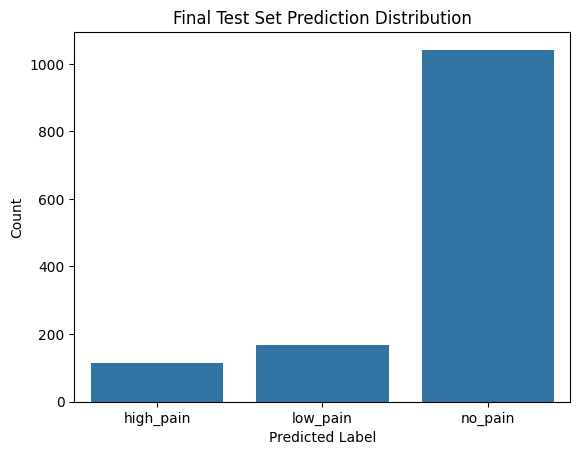


--- Top 5 Most Confused Samples (Smallest Confidence Margin) ---
              confidence_margin   no_pain  low_pain  high_pain
sample_index                                                  
867                    0.007961  0.493372  0.005296   0.501332
698                    0.014592  0.492693  0.507285   0.000022
1174                   0.070773  0.535379  0.464606   0.000014
171                    0.092569  0.061889  0.515340   0.422771
673                    0.096005  0.548002  0.451997   0.000002




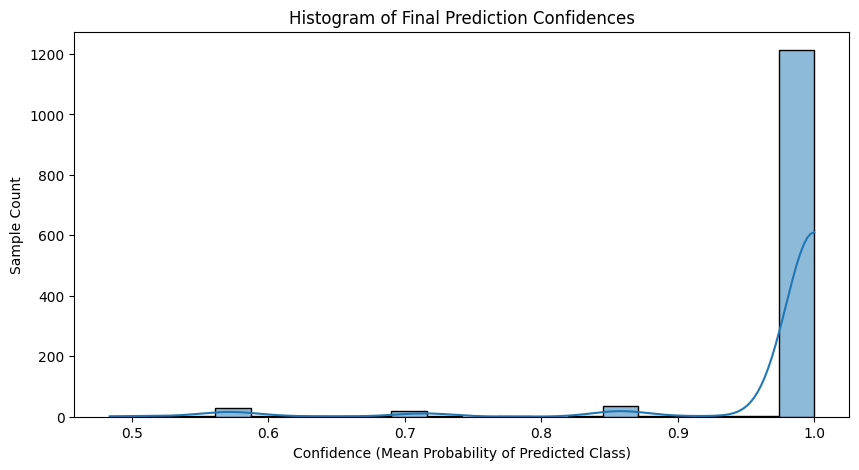


--- Plotting Window-by-Window Probabilities for Top 4 Most Confused Samples ---


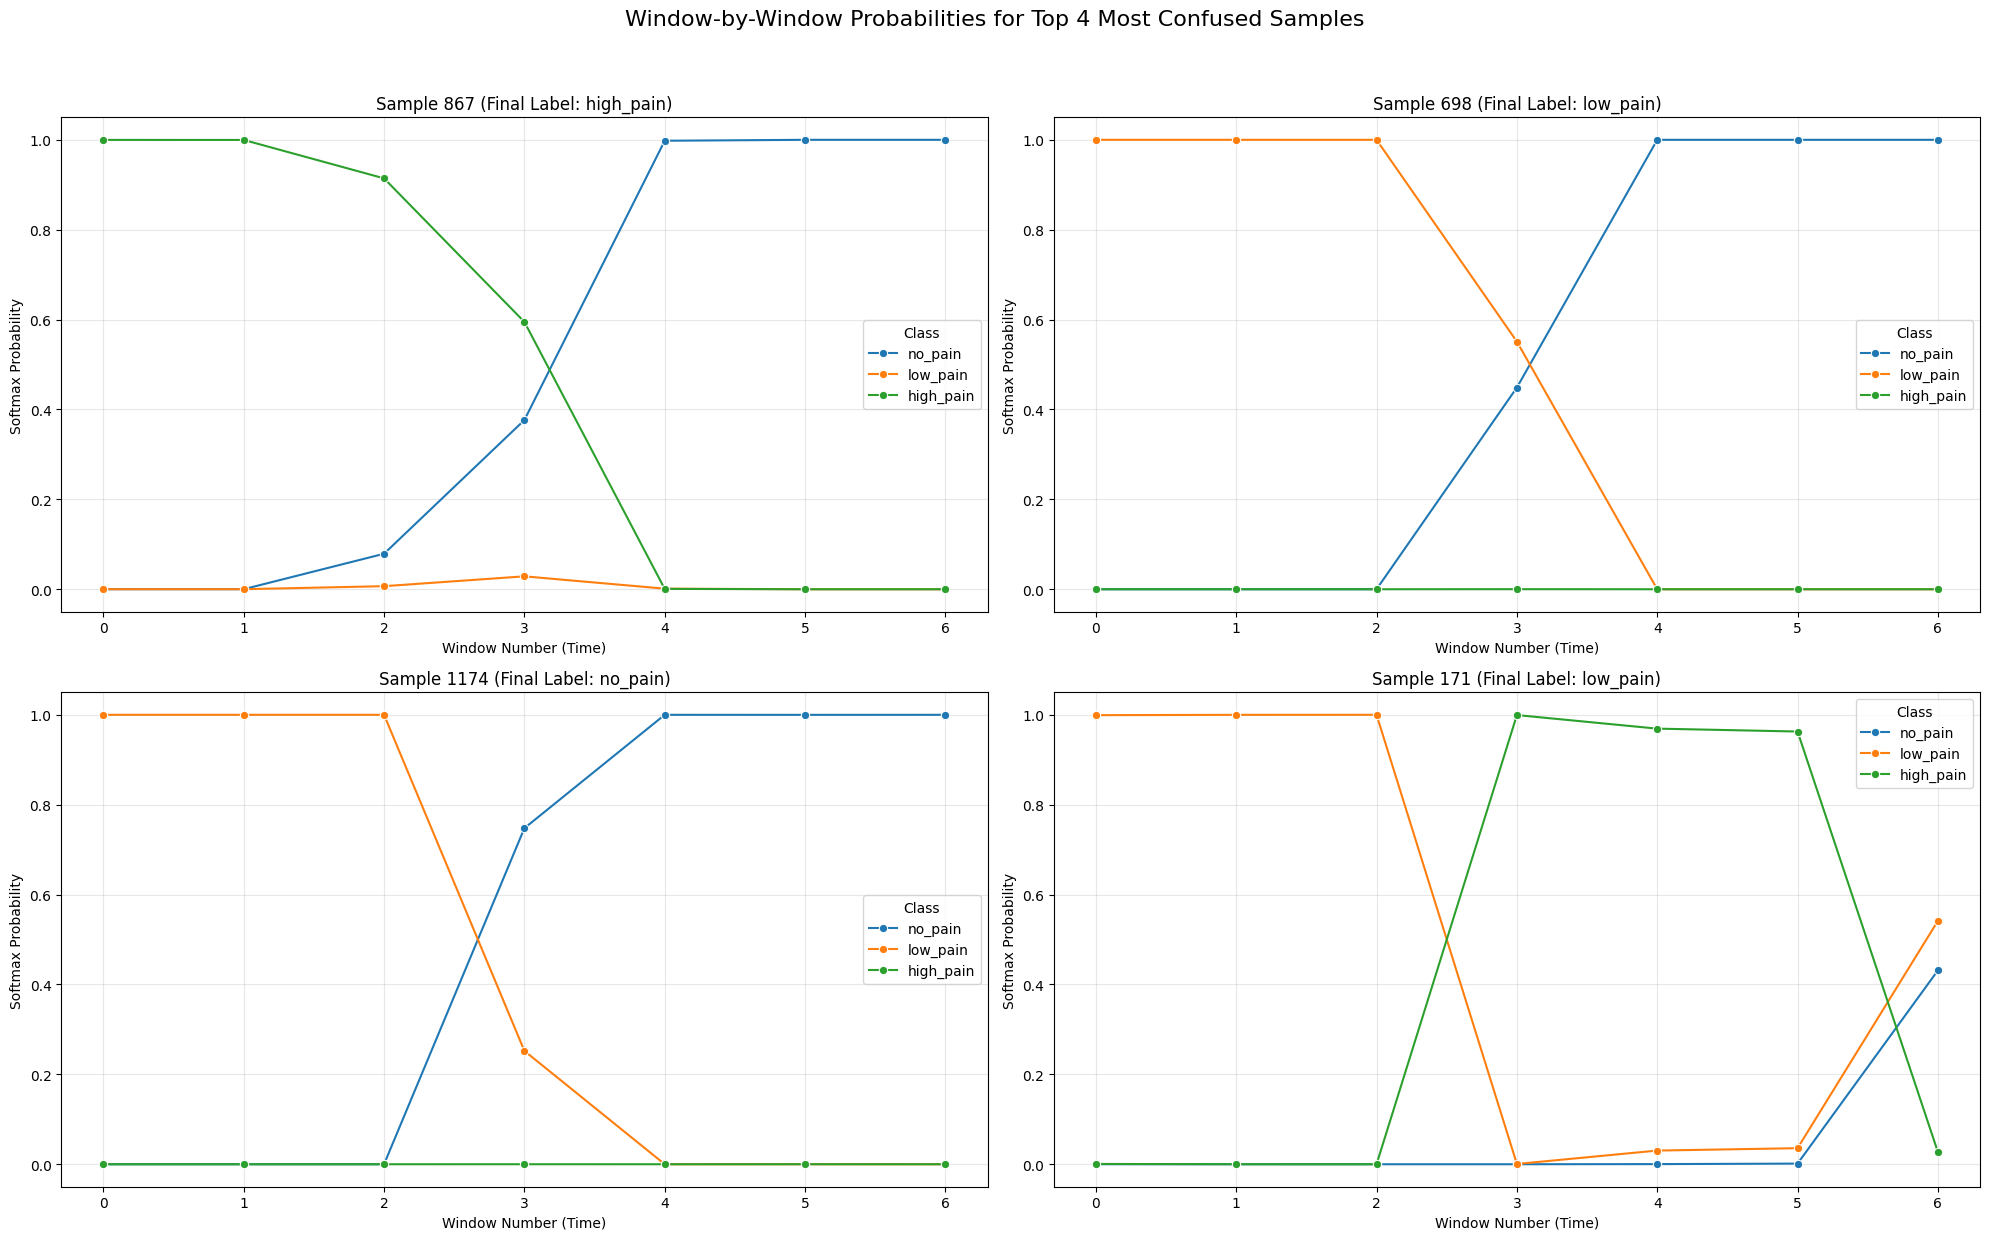

In [97]:
class TestWindowDataset(Dataset):
    def __init__(self, X_joints, X_pain, X_static, window_sample_indices, static_map):
        self.X_joints = torch.tensor(X_joints, dtype=torch.float32)
        self.X_pain = torch.tensor(X_pain, dtype=torch.float32)
        self.X_static_all = torch.tensor(X_static, dtype=torch.float32)
        self.window_sample_indices = window_sample_indices
        self.static_map = static_map

    def __getitem__(self, index):
        x_joints_sample = self.X_joints[index]
        x_pain_sample = self.X_pain[index]
        sample_index = self.window_sample_indices[index]
        static_idx = self.static_map.get(sample_index)
        
        if static_idx is None:
            x_static_sample = torch.zeros(self.X_static_all.shape[1], dtype=torch.float32)
        else:
            x_static_sample = self.X_static_all[static_idx]
            
        return (x_joints_sample, x_pain_sample, x_static_sample)
    
    def __len__(self):
        return self.X_joints.shape[0]
        
# This class is for the NON-HYBRID (standard) model
class TestWindowDatasetStandard(Dataset):
    def __init__(self, data):
        self.data = data
    def __getitem__(self, index):
        return self.data[index]
    def __len__(self):
        return self.data.shape[0]

print("\n--- Starting Test Set Prediction ---")
df_test = pd.read_csv('pirate_pain_test.csv')

float_cols = df_test.select_dtypes(include=['float64']).columns
for col in float_cols:
    df_test[col] = df_test[col].astype(np.float32)
inv_label_map = {v: k for k, v in label_map.items()}


# --- 1. Define Feature Columns (matching the training script) ---
all_original_joint_cols_test = [c for c in df_test.columns if c.startswith('joint_')]
test_joint_cols = all_original_joint_cols_test[:-1]
n_joint_cols_test = len(test_joint_cols) 

test_pain_cols = [c for c in df_test.columns if c.startswith('pain_survey_')]
n_pain_cols_test = len(test_pain_cols)

print(f"Test set: Using {n_joint_cols_test} joint features and {n_pain_cols_test} pain features.")

# --- 2. Create Static Test Features---
if USE_STATIC_FEATURES:
    print("Engineering test set static features...")
    static_cols_raw_test = [c for c in df_test.columns if c.startswith('n_')]
    df_static_test_raw = df_test.drop_duplicates(subset=['sample_index']).set_index('sample_index')[static_cols_raw_test]
    df_static_test_engineered = engineer_static_features(df_static_test_raw)
    
    for col in STATIC_FEATURES_LIST_ENGINEERED:
        if col not in df_static_test_engineered:
            print(f"Warning: Test set missing static col '{col}'. Filling with 0.")
            df_static_test_engineered[col] = 0
                
    df_static_test_engineered = df_static_test_engineered[STATIC_FEATURES_LIST_ENGINEERED]
    df_static_test_engineered = df_static_test_engineered.fillna(2)
    
    print("Normalizing test set static features...")
    static_range_test = GLOBAL_STATIC_MAX - GLOBAL_STATIC_MIN
    static_range_test[static_range_test == 0] = 1
    df_static_test_normalized = 2 * ((df_static_test_engineered[STATIC_FEATURES_LIST_ENGINEERED] - GLOBAL_STATIC_MIN) / static_range_test) - 1
    
    static_map_test = {sid: i for i, sid in enumerate(df_static_test_normalized.index)} 
    static_data_test = df_static_test_normalized.values # <-- Use normalized data

# --- 3. Window the Test Data ---

# Check for shape mismatch
if len(GLOBAL_JOINT_MIN) != n_joint_cols_test:
    print(f"FATAL ERROR: Shape mismatch. Training normalization stats have {len(GLOBAL_JOINT_MIN)} features, but test set is using {n_joint_cols_test}.")

    
global_min_tensor = torch.FloatTensor(GLOBAL_JOINT_MIN)
global_max_tensor = torch.FloatTensor(GLOBAL_JOINT_MAX)
global_range_tensor = global_max_tensor - global_min_tensor
global_range_tensor[global_range_tensor == 0] = 1
# ------------------------------------------------

test_windows_joints = []
test_windows_pain = []
test_window_indices = []

for sid in df_test['sample_index'].unique():
    seq_df = df_test[df_test['sample_index'] == sid]
    if len(seq_df) == 0:
        print(f"Warning: No features for test sample {sid}. Skipping.")
        continue
    
    # --- Get two separate feature sequences ---
    seq_joints = seq_df.sort_values('time')[test_joint_cols].values
    seq_pain = seq_df.sort_values('time')[test_pain_cols].values
        
    # --- Normalize  joint and pain data ---
    seq_tensor_joints = torch.FloatTensor(seq_joints)
    normalized_joints = 2 * ((seq_tensor_joints - global_min_tensor) / global_range_tensor) - 1
    seq_joints_normalized = normalized_joints.numpy()

    # Create pain tensors
    global_pain_min_tensor = torch.FloatTensor(GLOBAL_PAIN_MIN)
    global_pain_max_tensor = torch.FloatTensor(GLOBAL_PAIN_MAX)
    global_pain_range_tensor = global_pain_max_tensor - global_pain_min_tensor
    global_pain_range_tensor[global_pain_range_tensor == 0] = 1

    # Normalize pain data
    seq_tensor_pain = torch.FloatTensor(seq_pain)
    normalized_pain = 2 * ((seq_tensor_pain - global_pain_min_tensor) / global_pain_range_tensor) - 1
    seq_pain_normalized = normalized_pain.numpy()
    
    # --- Padding ---
    padding_len = WINDOW_SIZE - len(seq_joints_normalized) % WINDOW_SIZE
    if padding_len < WINDOW_SIZE:
        padding_joint = np.zeros((padding_len, n_joint_cols_test), dtype='float32')
        padding_pain = np.zeros((padding_len, n_pain_cols_test), dtype='float32')
        
        seq_joints_padded = np.concatenate((seq_joints_normalized, padding_joint))
        seq_pain_padded = np.concatenate((seq_pain_normalized, padding_pain))
    else:
        seq_joints_padded = seq_joints_normalized
        seq_pain_padded = seq_pain_normalized
        
    # --- Windowing ---
    idx = 0
    while idx + WINDOW_SIZE <= len(seq_joints_padded):
        test_windows_joints.append(seq_joints_padded[idx:idx + WINDOW_SIZE])
        test_windows_pain.append(seq_pain_padded[idx:idx + WINDOW_SIZE])
        test_window_indices.append(sid)
        idx += STRIDE

X_test_windows_joints = np.array(test_windows_joints)
X_test_windows_pain = np.array(test_windows_pain)
print(f"Created {len(X_test_windows_joints)} test windows from {df_test['sample_index'].nunique()} samples.")

# --- 4. Create Test DataLoader ---
if USE_STATIC_FEATURES:
    test_dataset = TestWindowDataset(X_test_windows_joints, X_test_windows_pain, static_data_test, test_window_indices, static_map_test)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
else:
    # This path is now more complex, as it would need to recombine joints and pain.
    # Sticking to the 3-branch hybrid path for simplicity as USE_STATIC_FEATURES=True
    print("Warning: Non-hybrid mode is not supported with this 3-branch preprocessing.")
    # Fallback to keep code running (assuming USE_STATIC_FEATURES is True)
    test_dataset = TestWindowDataset(X_test_windows_joints, X_test_windows_pain, static_data_test, test_window_indices, static_map_test)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    
# --- 5. Get predictions for ALL windows (Collecting RAW SCORES) ---
try:
    model_path = f"models/{experiment_name}_model.pt"
    rnn_model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Successfully loaded best model from {model_path}")
except Exception as e:
    print(f"Warning: Could not load saved model. Using last epoch model. Error: {e}")

rnn_model.eval() 
window_raw_scores = [] 
window_sample_indices_collected = []

with torch.no_grad():
    for inputs in test_loader:
        if USE_STATIC_FEATURES:
            x_joints, x_pain, x_static = inputs
            x_joints = x_joints.to(device)
            x_pain = x_pain.to(device)
            x_static = x_static.to(device)
            outputs = rnn_model(x_joints, x_pain, x_static)
        else:
             # This path is likely broken now, but kept for logical flow
            x_temporal = inputs
            x_temporal = x_temporal.to(device)
            outputs = rnn_model(x_temporal)
        
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
        window_raw_scores.append(probabilities)
        
        start_idx = len(window_sample_indices_collected)
        batch_indices = test_window_indices[start_idx : start_idx + len(probabilities)]
        window_sample_indices_collected.extend(batch_indices)

score_cols = [inv_label_map[i] for i in range(num_classes)]
window_raw_scores = np.concatenate(window_raw_scores, axis=0)

df_window_scores = pd.DataFrame(window_raw_scores, columns=score_cols)
df_window_scores['sample_index'] = window_sample_indices_collected


# --- 6. Combine window predictions (MEAN PROBABILITY VOTE) ---
def get_mean_probability_vote(df_group, score_columns):
    """Calculates the mean probability across all windows and returns the label with the highest mean."""
    mean_scores = df_group[score_columns].mean(axis=0)
    return mean_scores.idxmax()

# Apply the mean vote across all samples
final_predictions_df = df_window_scores.groupby('sample_index')[score_cols].apply(
    lambda x: get_mean_probability_vote(x, score_cols)
)
final_predictions_df.name = 'label' # Rename the series to 'label'

# Format for submission
submission_df = final_predictions_df.reset_index()
submission_df['sample_index'] = submission_df['sample_index'].apply(lambda x: f"{int(x):03d}")

# Ensure all test samples are present (for submissions)
all_test_sids = pd.DataFrame({'sample_index': [f"{int(idx):03d}" for idx in df_test['sample_index'].unique()]})
submission_df = all_test_sids.merge(submission_df, on='sample_index', how='left')

# Fill missing predictions
if 'y_train' in locals() and len(y_train) > 0:
    majority_class_numeric = pd.Series(y_train).mode().iloc[0]
    majority_class_label = inv_label_map[majority_class_numeric]
else:
    majority_class_label = inv_label_map[0] 
    
print(f"Filling {submission_df['label'].isna().sum()} missing predictions with majority class '{majority_class_label}'")
submission_df['label'] = submission_df['label'].fillna(majority_class_label)


# --- 7. Print and Plot Test Set Results ---
print("\n--- Final Test Set Predictions Summary ---")
print(submission_df['label'].value_counts(normalize=True))
print("\n---")

# Plot the distribution
sns.countplot(x='label', data=submission_df, order=sorted(label_map.keys()))
plt.title('Final Test Set Prediction Distribution')
plt.xlabel('Predicted Label')
plt.ylabel('Count')
plt.show()

# --- 7b. Plot Final Prediction Confidence (HISTOGRAM) ---

# Get the mean probabilities for each class, for each sample
mean_probs_per_sample = df_window_scores.groupby('sample_index')[score_cols].mean()

# Get the *highest* mean probability (the confidence of the winning class)
final_confidences = mean_probs_per_sample.max(axis=1)


# --- Print Most Confused Samples ---
sorted_probs = np.sort(mean_probs_per_sample.values, axis=1)
top_1_probs = sorted_probs[:, -1]
top_2_probs = sorted_probs[:, -2]
mean_probs_per_sample['confidence_margin'] = top_1_probs - top_2_probs

print("\n--- Top 5 Most Confused Samples (Smallest Confidence Margin) ---")
print(mean_probs_per_sample.nsmallest(5, 'confidence_margin')[['confidence_margin'] + score_cols])
print("\n")

# Plot the histogram of these confidences
plt.figure(figsize=(10, 5))
sns.histplot(final_confidences, kde=True, bins=20)
plt.title('Histogram of Final Prediction Confidences')
plt.xlabel('Confidence (Mean Probability of Predicted Class)')
plt.ylabel('Sample Count')
plt.show()

most_confused_samples = mean_probs_per_sample.nsmallest(4, 'confidence_margin')
most_confused_indices = most_confused_samples.index

print(f"\n--- Plotting Window-by-Window Probabilities for Top {len(most_confused_indices)} Most Confused Samples ---")

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
for ax, sample_to_plot in zip(axes.flatten(), most_confused_indices):
    
    final_label = submission_df[submission_df['sample_index'] == f"{int(sample_to_plot):03d}"]['label'].values[0]

    df_sample = df_window_scores[df_window_scores['sample_index'] == sample_to_plot]

    df_sample_melted = df_sample.reset_index(drop=True).rename_axis('window_num').reset_index()
    df_sample_melted = df_sample_melted.melt(id_vars=['window_num'], value_vars=score_cols, var_name='class_label', value_name='probability')

    sns.lineplot(data=df_sample_melted, x='window_num', y='probability', hue='class_label', marker='o', ax=ax)
    ax.set_title(f'Sample {sample_to_plot} (Final Label: {final_label})')
    ax.set_xlabel('Window Number (Time)')
    ax.set_ylabel('Softmax Probability')
    ax.legend(title='Class')
    ax.grid(alpha=0.3)

plt.suptitle('Window-by-Window Probabilities for Top 4 Most Confused Samples', fontsize=16, y=1.03)
plt.tight_layout()
plt.show()



## Submission

In [98]:
# %% [code]
# --- 8. Save to CSV and TXT ---
os.makedirs("submissions", exist_ok=True)
os.makedirs("submissions_probs", exist_ok=True)

# 1. Save CSV (Final Labels - Original Request)
NAME_CSV_PREDICTION = f"submissions/submission_{experiment_name}.csv"
submission_df[['sample_index', 'label']].to_csv(NAME_CSV_PREDICTION, index=False)
print(f"Predictions saved to {NAME_CSV_PREDICTION}")

# 2. Prepare Data for TXT (Labels + Probabilities)
# df_txt uses mean_probs_per_sample (from the analysis cell) which contains the raw probabilities.

# Copy mean probabilities and ensure sample_index is a column
df_txt = mean_probs_per_sample.copy().reset_index()

# Merge the final label column (which is in submission_df)
df_txt['sample_index'] = df_txt['sample_index'].apply(lambda x: f"{int(x):03d}")

# Reorder columns: sample_index, final_label, prob_class1, prob_class2, ...
df_txt = df_txt.merge(submission_df[['sample_index', 'label']], on='sample_index', how='left')

df_txt = df_txt[['sample_index', 'label'] + score_cols]
# 3. Save TXT File (Include SEED in filename for traceability)
# Filename format: submission_probs_final_model_59_epochs_TIMESTAMP_SEED100.txt
NAME_TXT_PROBS = f"submissions_probs/submission_probs_{experiment_name}_SEED{SEED}.txt"

# Save using tab separator, without the index, and with the header
df_txt.to_csv(NAME_TXT_PROBS, sep='\t', index=False)
print(f"Probabilities saved to {NAME_TXT_PROBS}")

print(submission_df.head())

Predictions saved to submissions/submission_final_model_40_epochs_20251114_013622.csv
Probabilities saved to submissions_probs/submission_probs_final_model_40_epochs_20251114_013622_SEED100.txt
  sample_index    label
0          000  no_pain
1          001  no_pain
2          002  no_pain
3          003  no_pain
4          004  no_pain
